# Get 2D Synthetic Data from Trained Flow 

Here I use Neural Spline Flow

In [1]:
# Import required packages
import torch
import numpy as np
import normflows as nf
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt
from tqdm import tqdm

# internal imports
import sys
sys.path.append('..')
from datasets.data_generator import *

/home/ywu380/miniconda3/envs/cdl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data preparision
Here use two-moons as an example, to generate flow synthetic data see ../datasets/flow_synthetic.py

In [2]:
# set up the flow model

# define flow
K = 16
torch.manual_seed(0)

latent_size = 2
hidden_units = 128
hidden_layers = 2

flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# set base distribution
q0 = nf.distributions.DiagGaussian(2, trainable=False)

# construct flow
nfm = nf.NormalizingFlow(q0=q0, flows=flows)

# move model on GPU
enable_cuda = True
device = torch.device('cuda:0' if torch.cuda.is_available() and enable_cuda else 'cpu')
nfm = nfm.to(device)

Plot the data

spirals type = <class 'numpy.ndarray'>, shape = (1048576, 2)


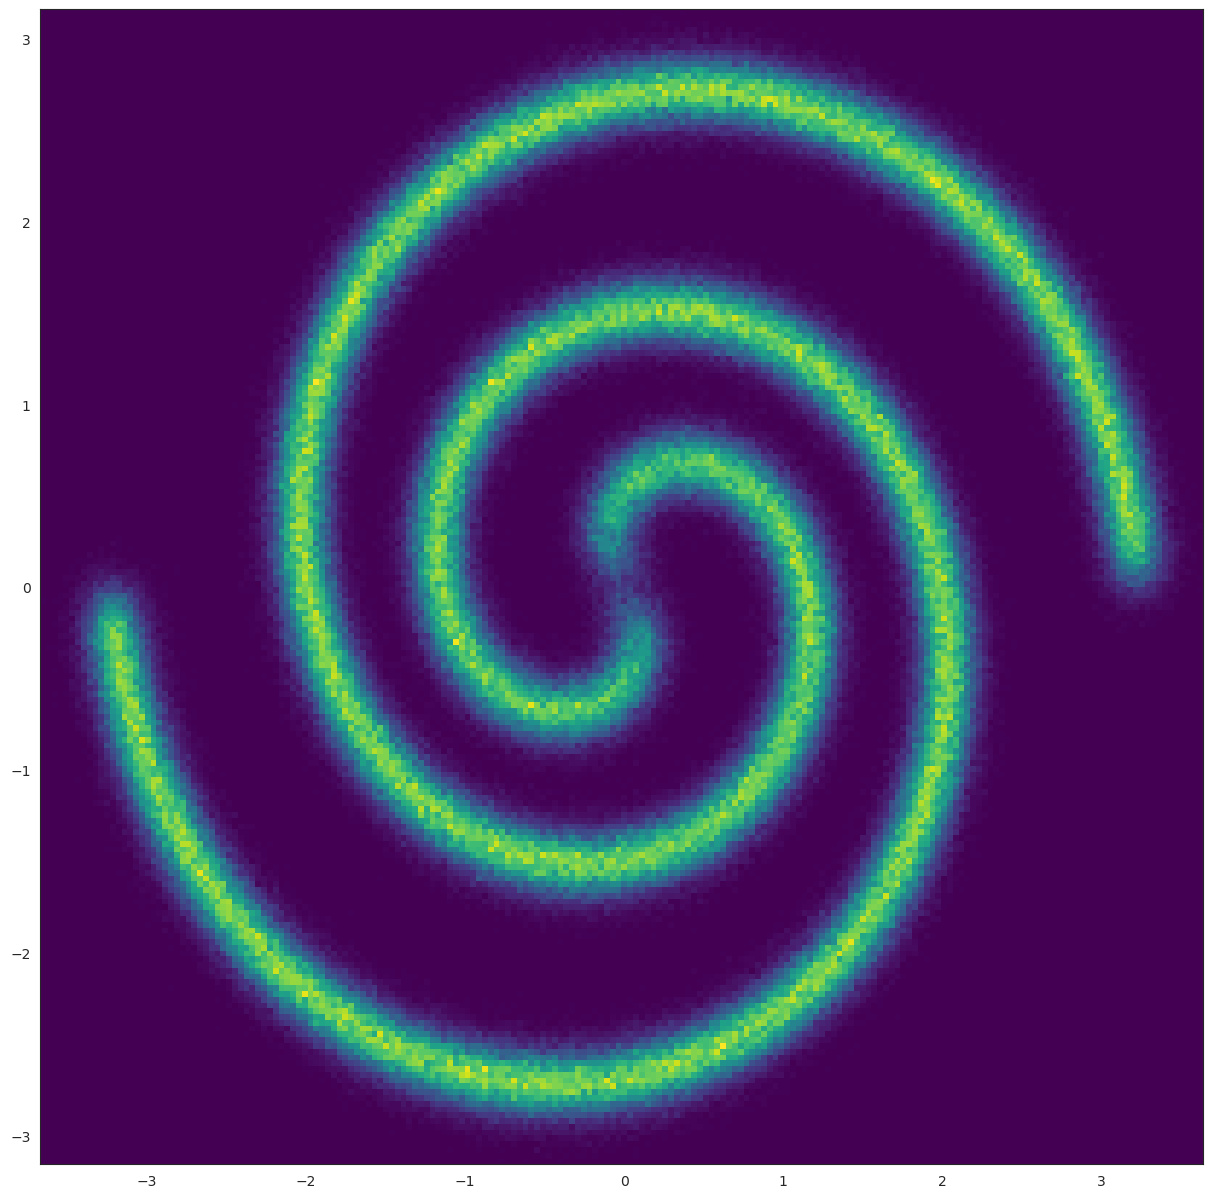

In [3]:
x_np = two_spirals(2 ** 20)
print(f'spirals type = {type(x_np)}, shape = {x_np.shape}')
plt.figure(figsize=(15, 15))
plt.hist2d(x_np[:, 0], x_np[:, 1], bins=200, cmap='viridis')
plt.show()

In [4]:
# plot initial flow distribution, should be a standard gaussian
# make the grid
grid_size = 100
xx, yy = torch.meshgrid(torch.linspace(-3.5, 3.5, grid_size), torch.linspace(-3.5, 3.5, grid_size))
print(f'xx.shape = {xx.shape}\nxx = {xx}, given shape to be [100,100], xx and yy should cover all 100*100 pairs in the grid space')
print(f'add a dim to {xx.unsqueeze(2).shape}')
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2)
print(f'zz.shape = {zz.shape}\nThis should be a point on the grid: zz[0][6]={zz[0][6]}')
zz = zz.view(-1,2) # to make all points on grid a sequence of coordinates (xxi,yyi)
print(zz.shape)
zz = zz.to(device)

xx.shape = torch.Size([100, 100])
xx = tensor([[-3.5000, -3.5000, -3.5000,  ..., -3.5000, -3.5000, -3.5000],
        [-3.4293, -3.4293, -3.4293,  ..., -3.4293, -3.4293, -3.4293],
        [-3.3586, -3.3586, -3.3586,  ..., -3.3586, -3.3586, -3.3586],
        ...,
        [ 3.3586,  3.3586,  3.3586,  ...,  3.3586,  3.3586,  3.3586],
        [ 3.4293,  3.4293,  3.4293,  ...,  3.4293,  3.4293,  3.4293],
        [ 3.5000,  3.5000,  3.5000,  ...,  3.5000,  3.5000,  3.5000]]), given shape to be [100,100], xx and yy should cover all 100*100 pairs in the grid space
add a dim to torch.Size([100, 100, 1])
zz.shape = torch.Size([100, 100, 2])
This should be a point on the grid: zz[0][6]=tensor([-3.5000, -3.0758])
torch.Size([10000, 2])


/home/ywu380/miniconda3/envs/cdl/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


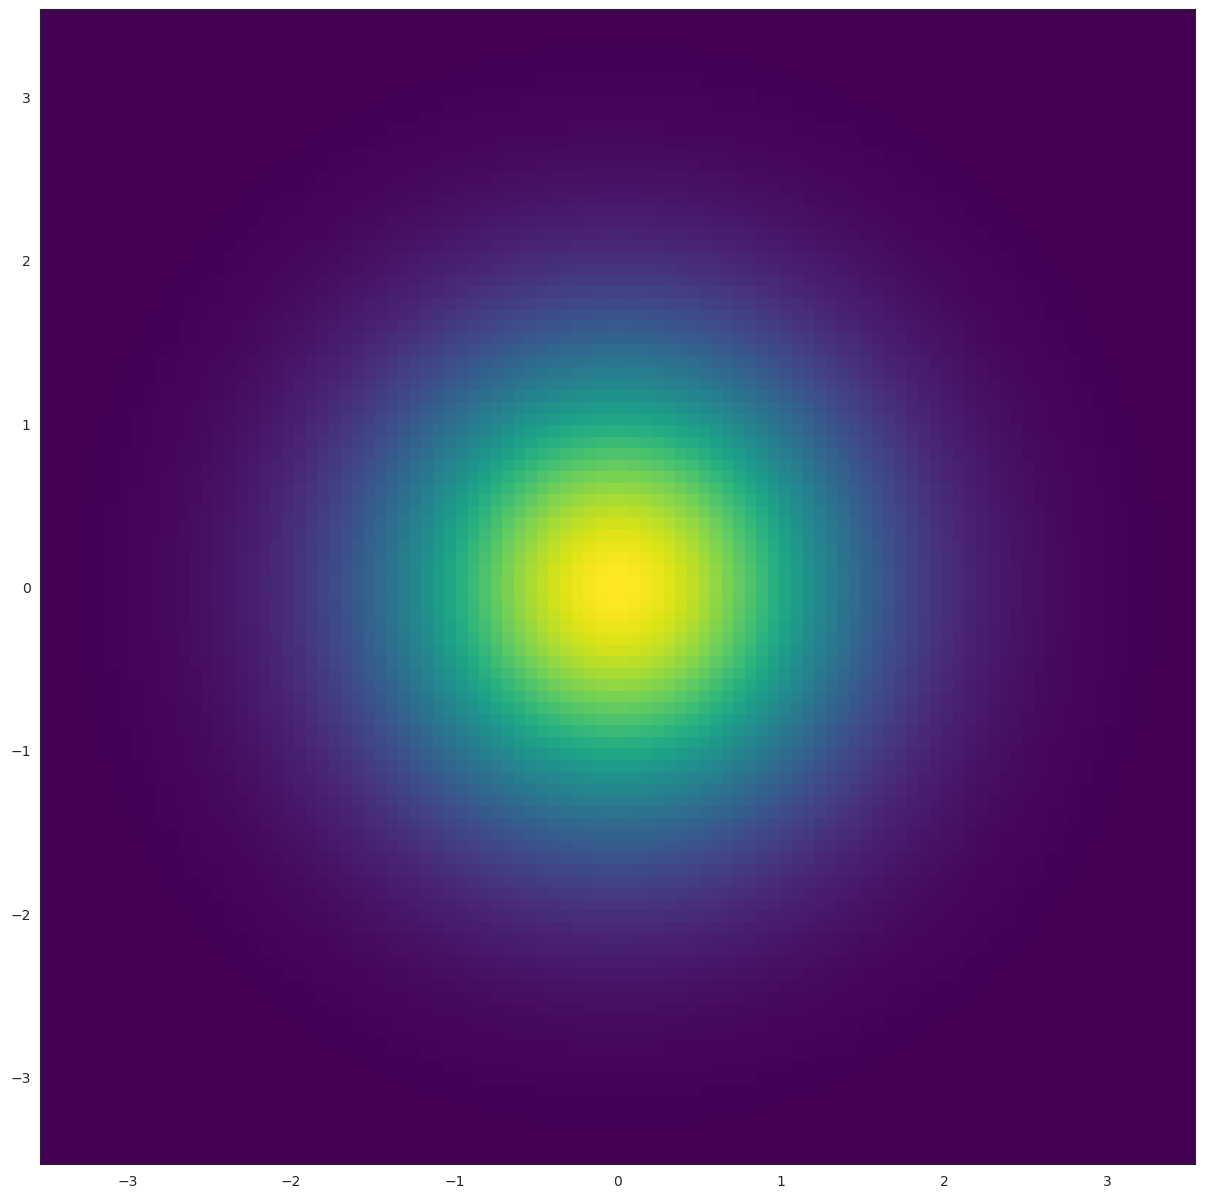

In [5]:
# plot the initial flow dist
nfm.eval()
log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape) # reshape log-prob to xx's shape
nfm.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0 # all points on grid which are not having values, should be assigned prob=0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='viridis')
plt.gca().set_aspect('equal', 'box')
plt.show()

## Train flow model

  5%|▍         | 499/10000 [00:53<16:51,  9.39it/s]

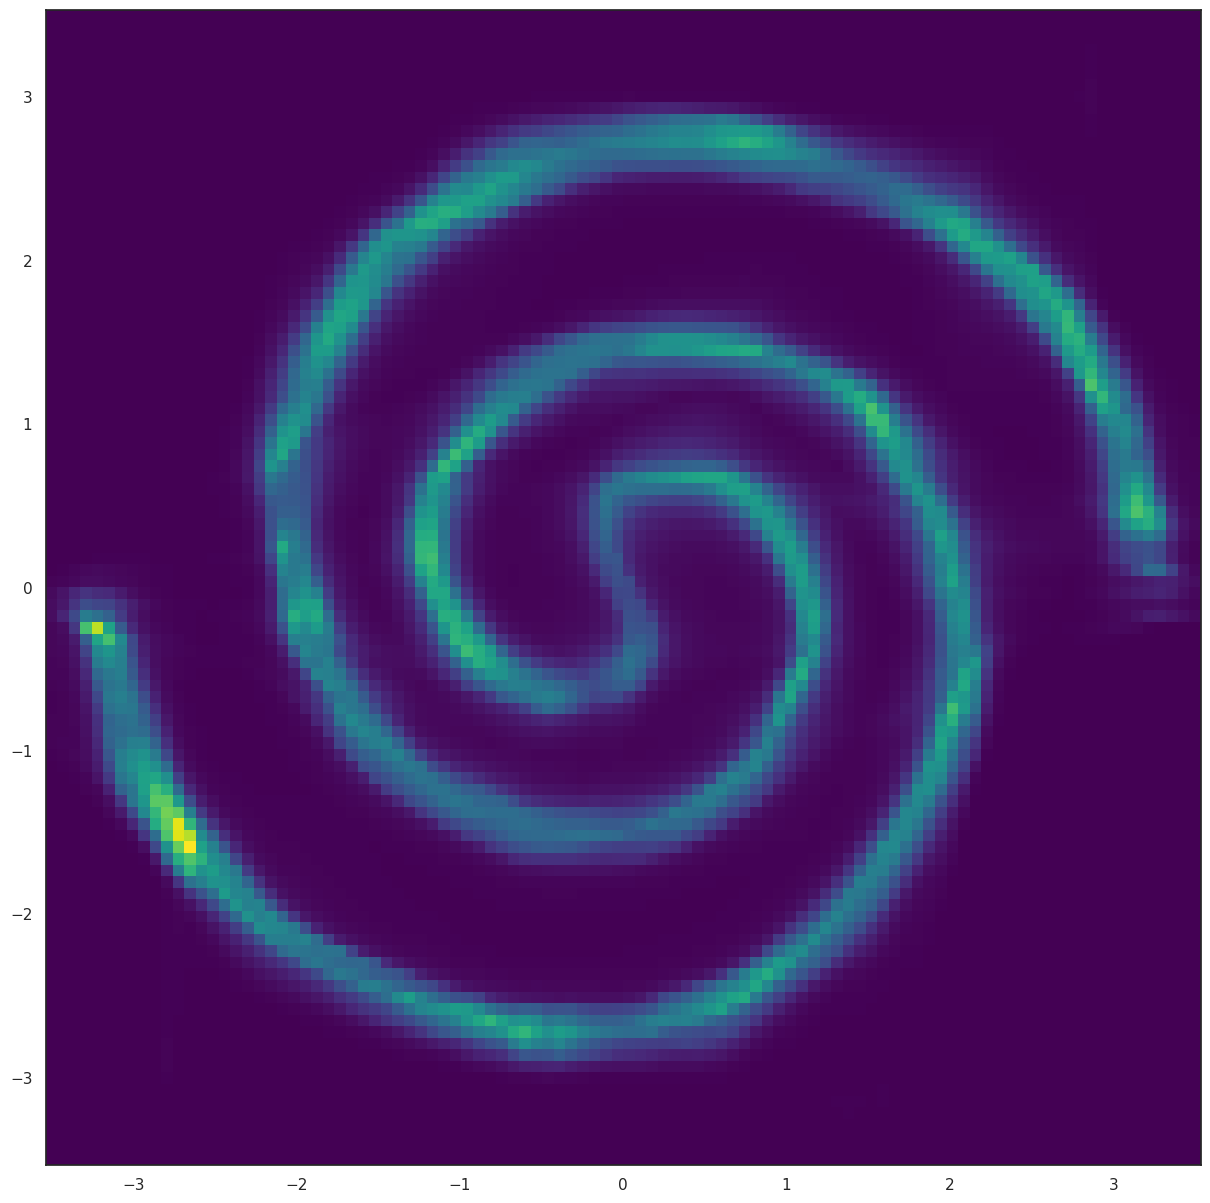

 10%|▉         | 998/10000 [01:57<16:04,  9.33it/s]

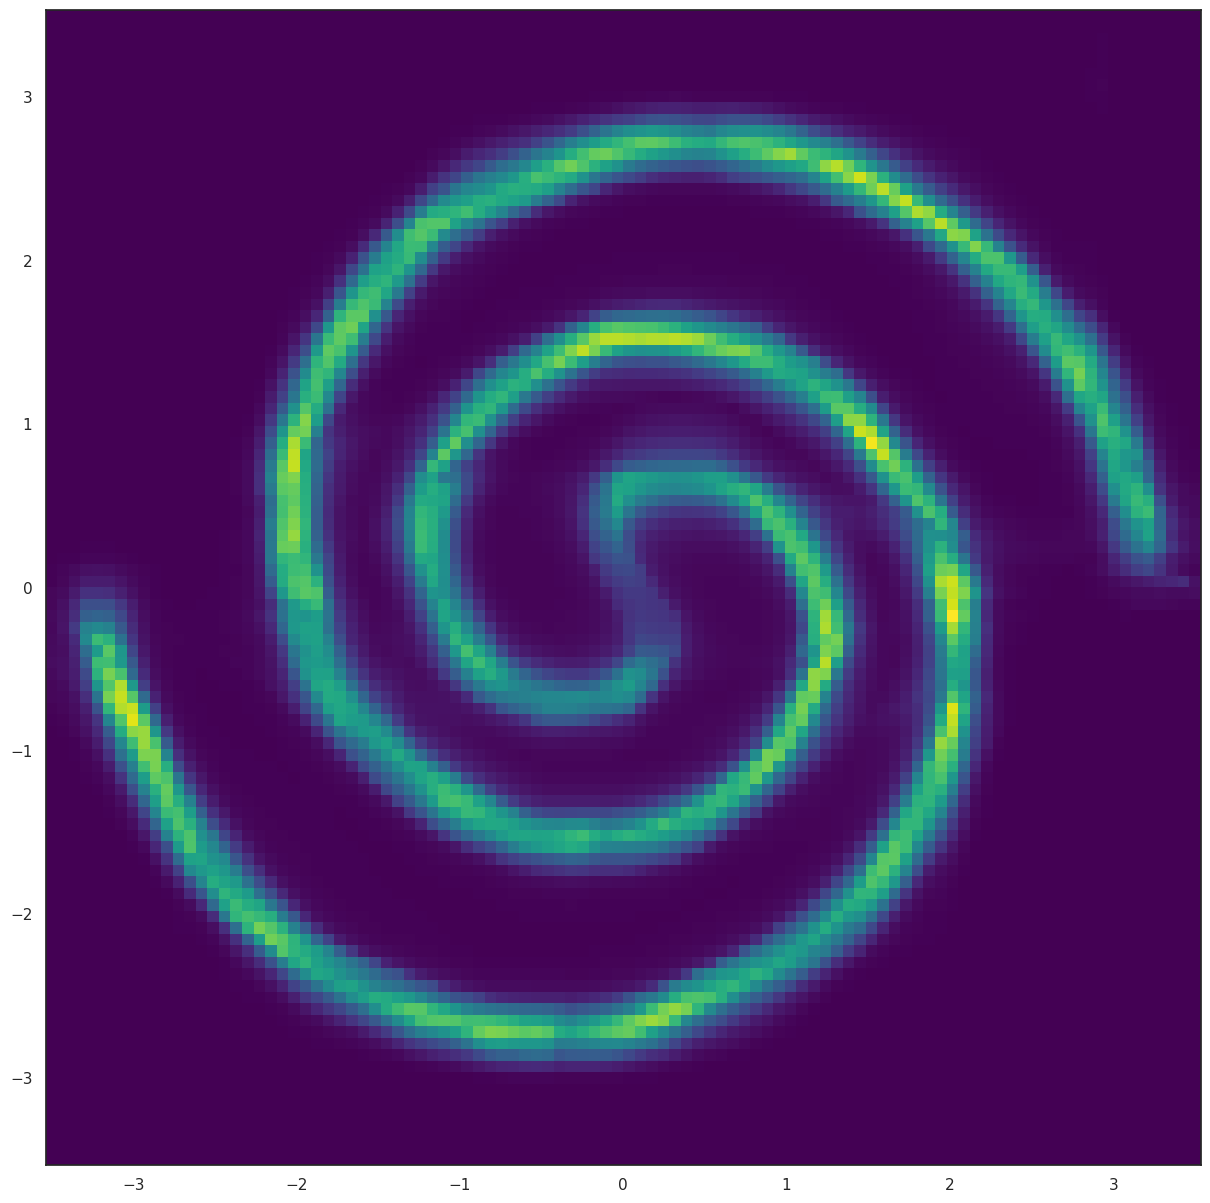

 15%|█▍        | 1499/10000 [02:53<15:16,  9.27it/s]  

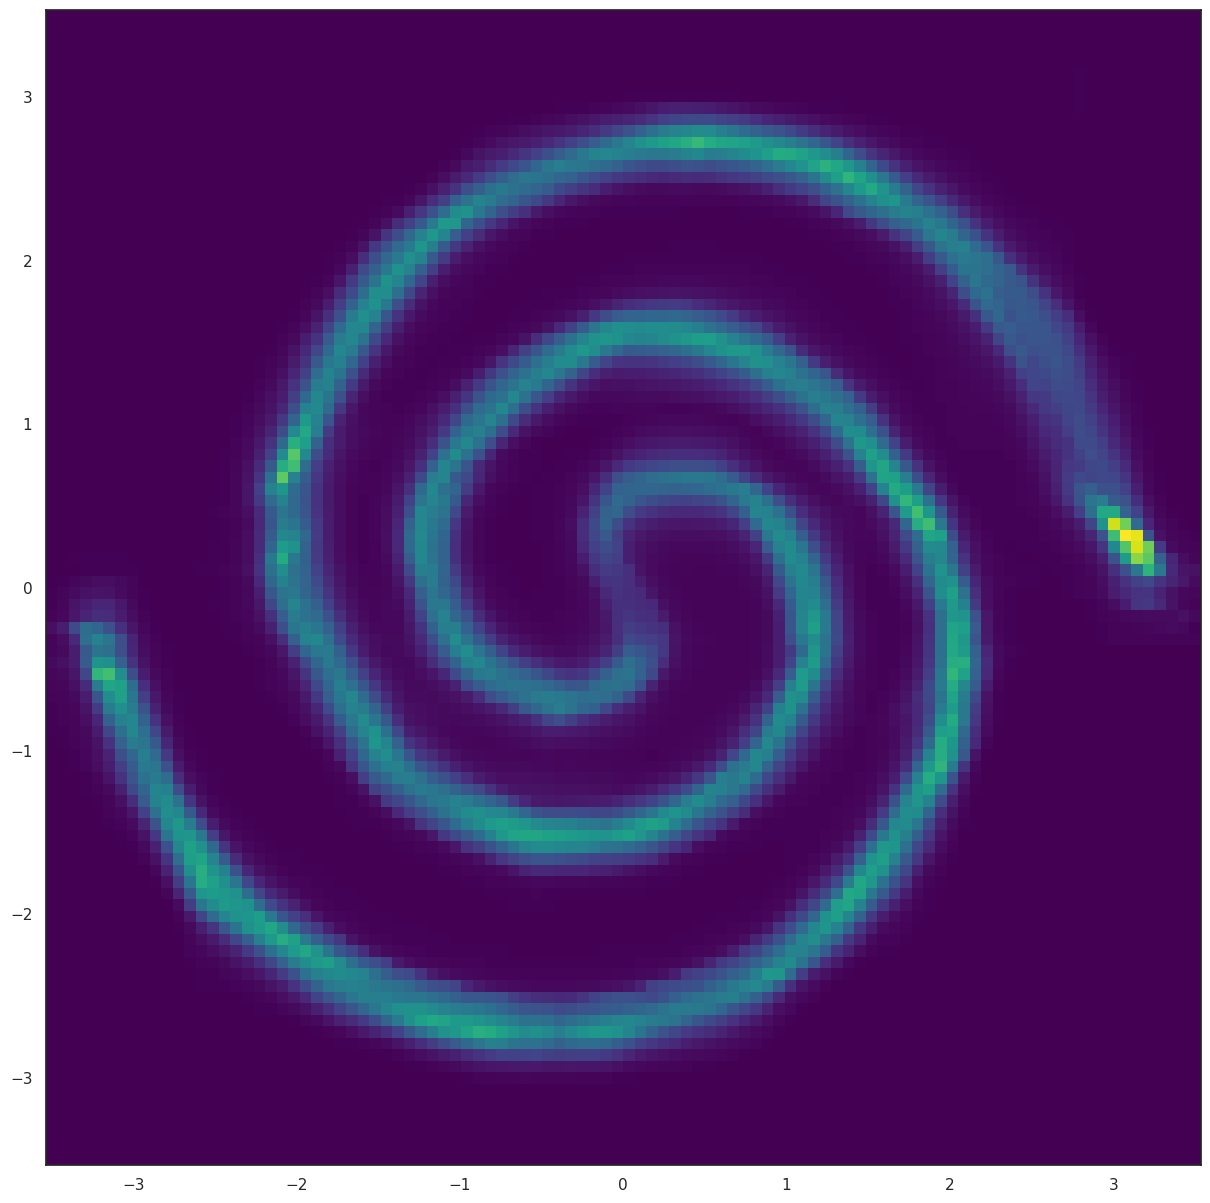

 20%|█▉        | 1999/10000 [03:47<14:23,  9.27it/s]

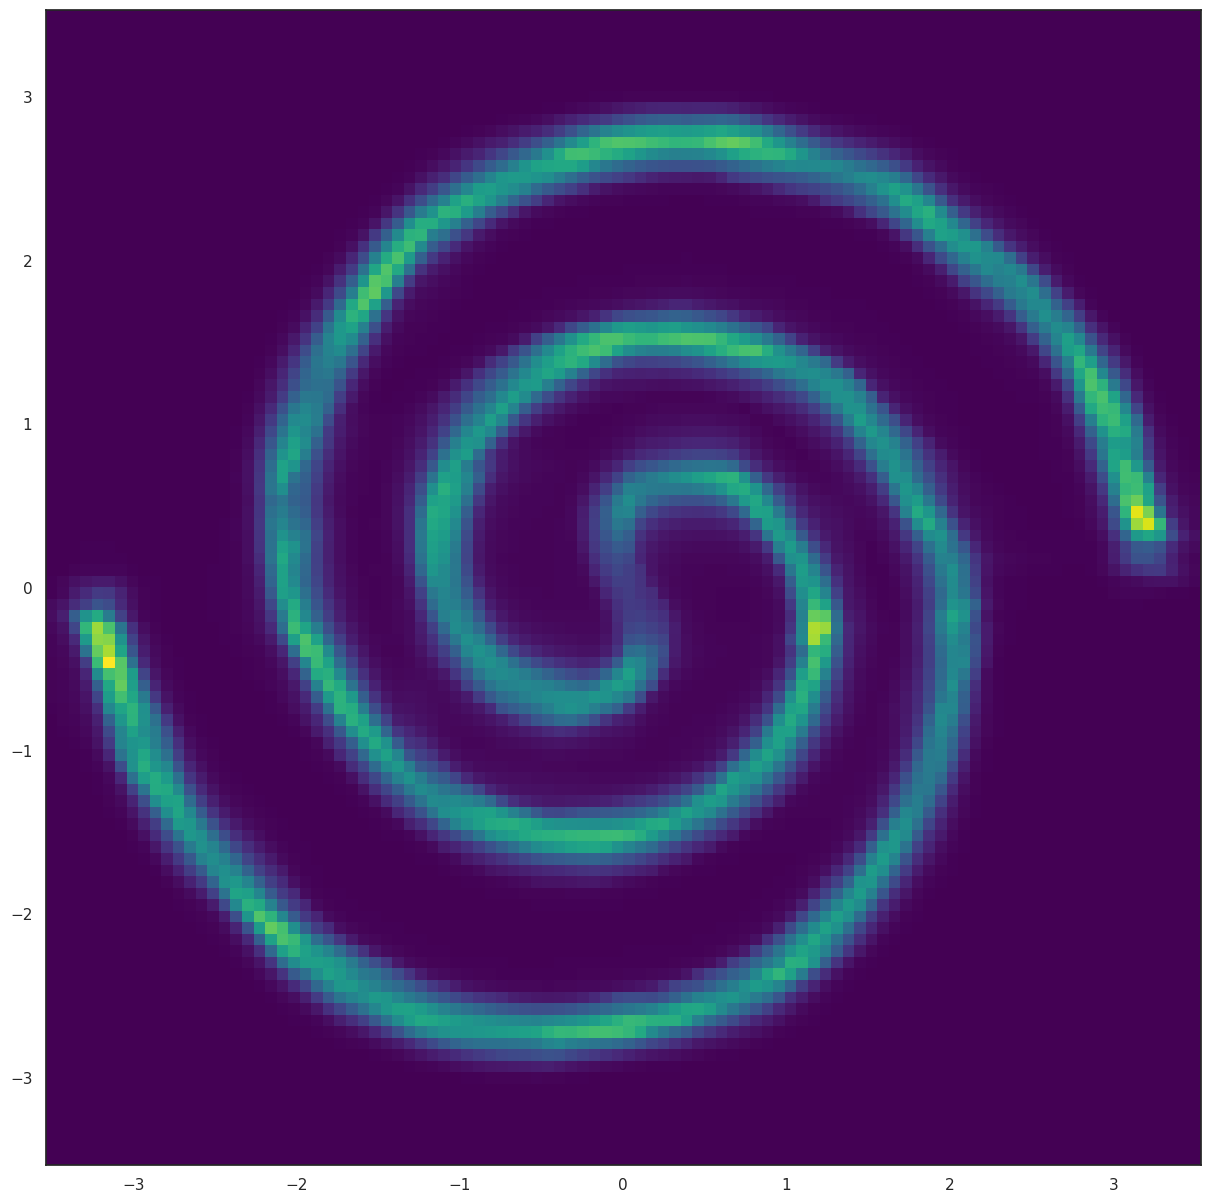

 25%|██▍       | 2499/10000 [04:40<13:19,  9.38it/s]

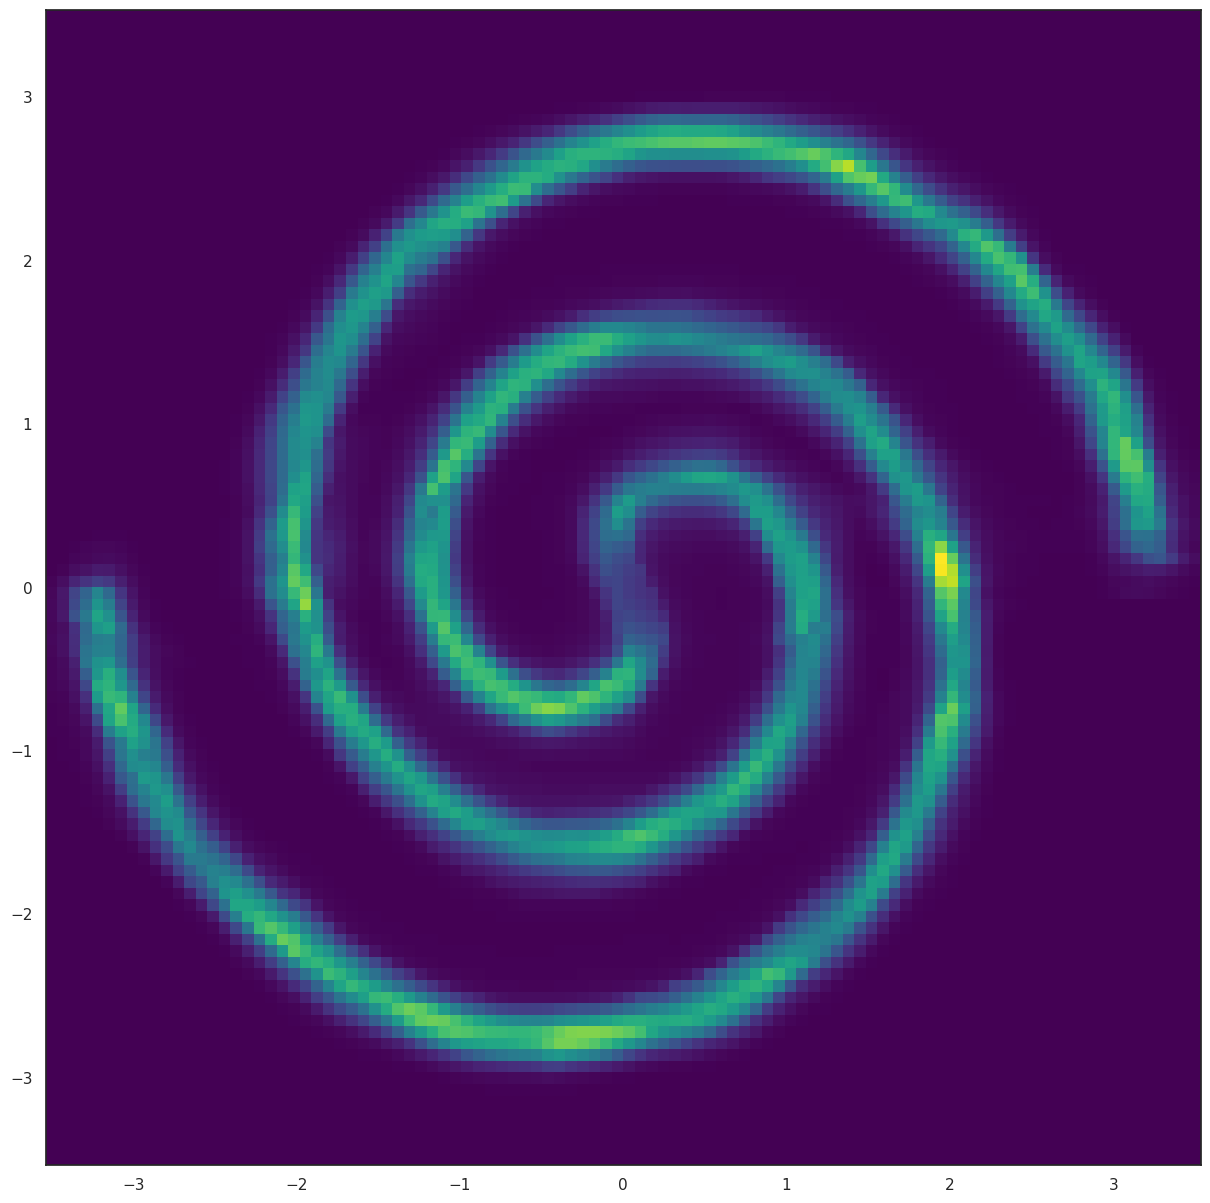

 30%|██▉       | 2999/10000 [05:33<12:37,  9.24it/s]

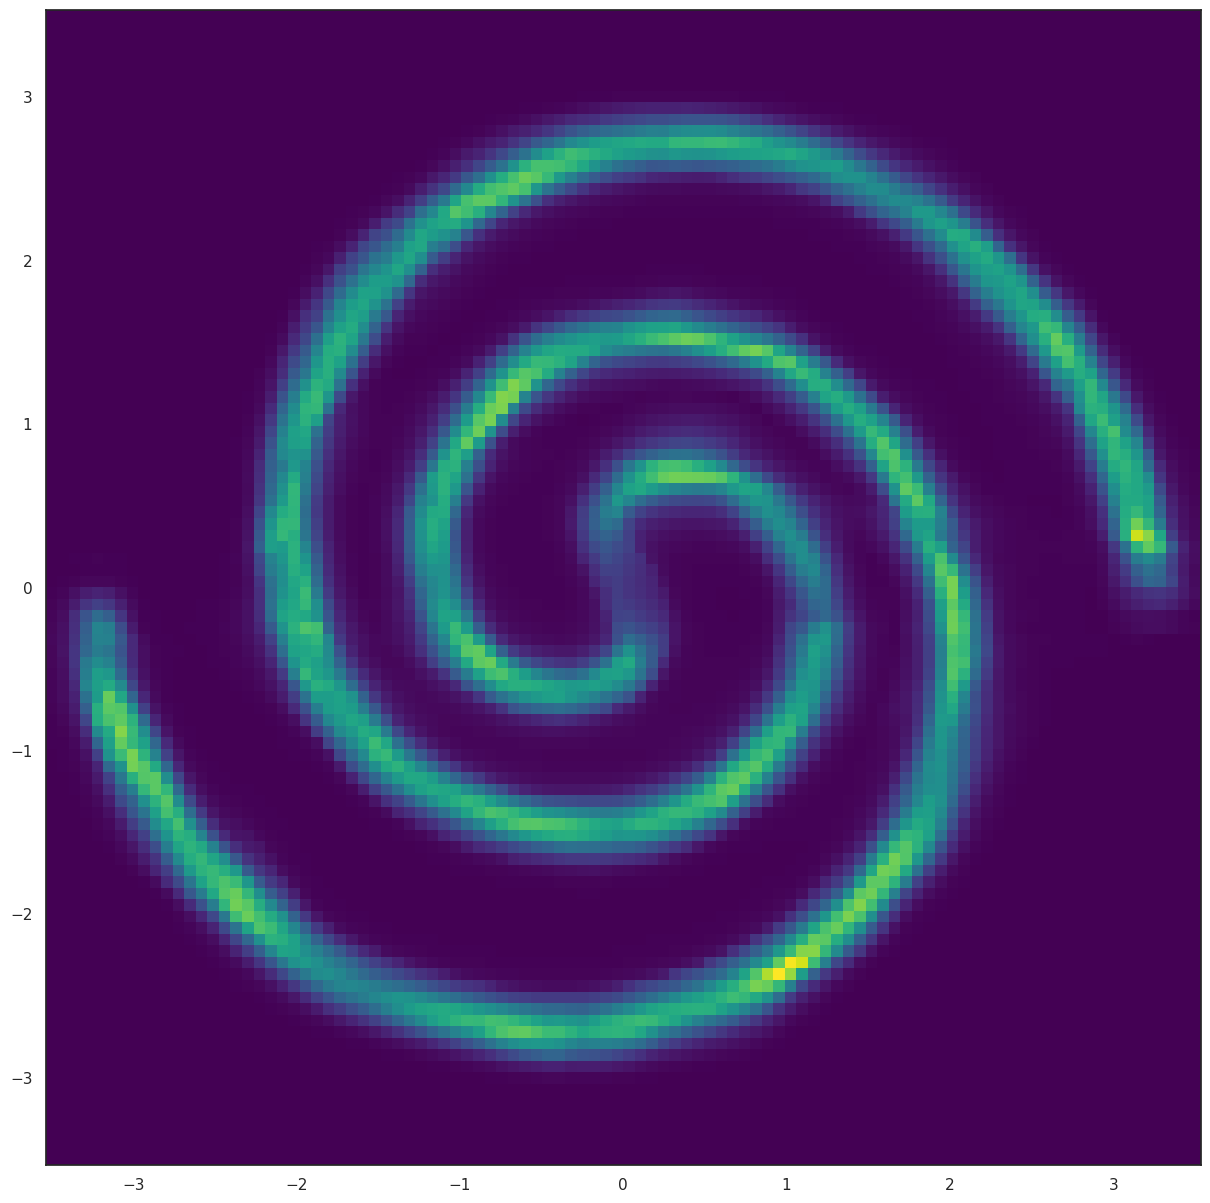

 35%|███▍      | 3499/10000 [06:26<12:25,  8.72it/s]

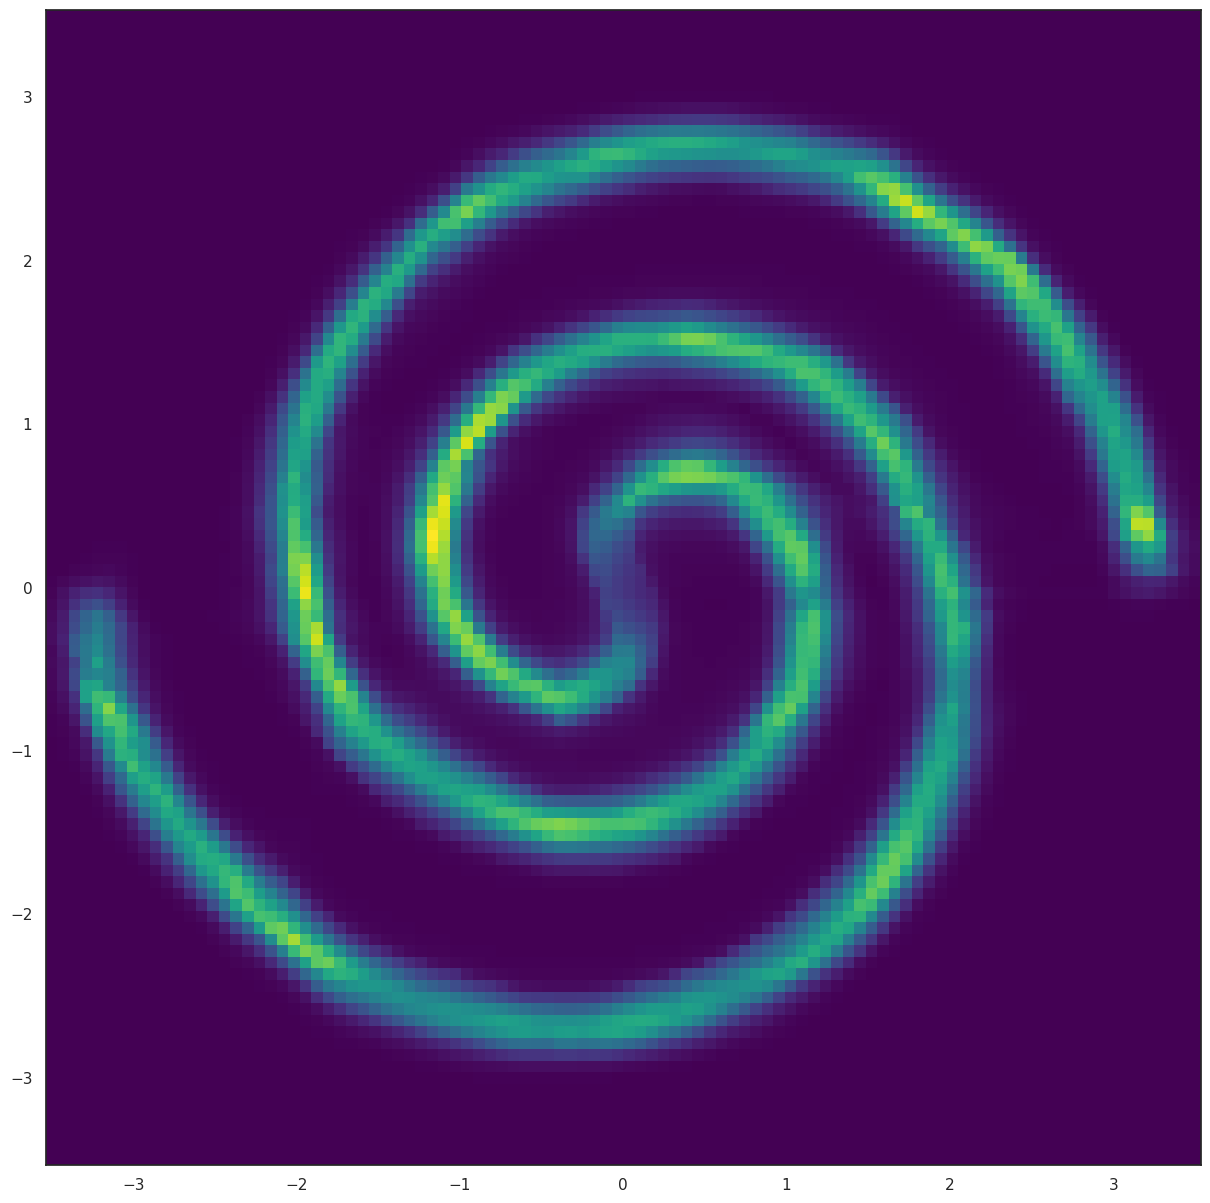

 40%|███▉      | 3999/10000 [07:20<10:45,  9.29it/s]

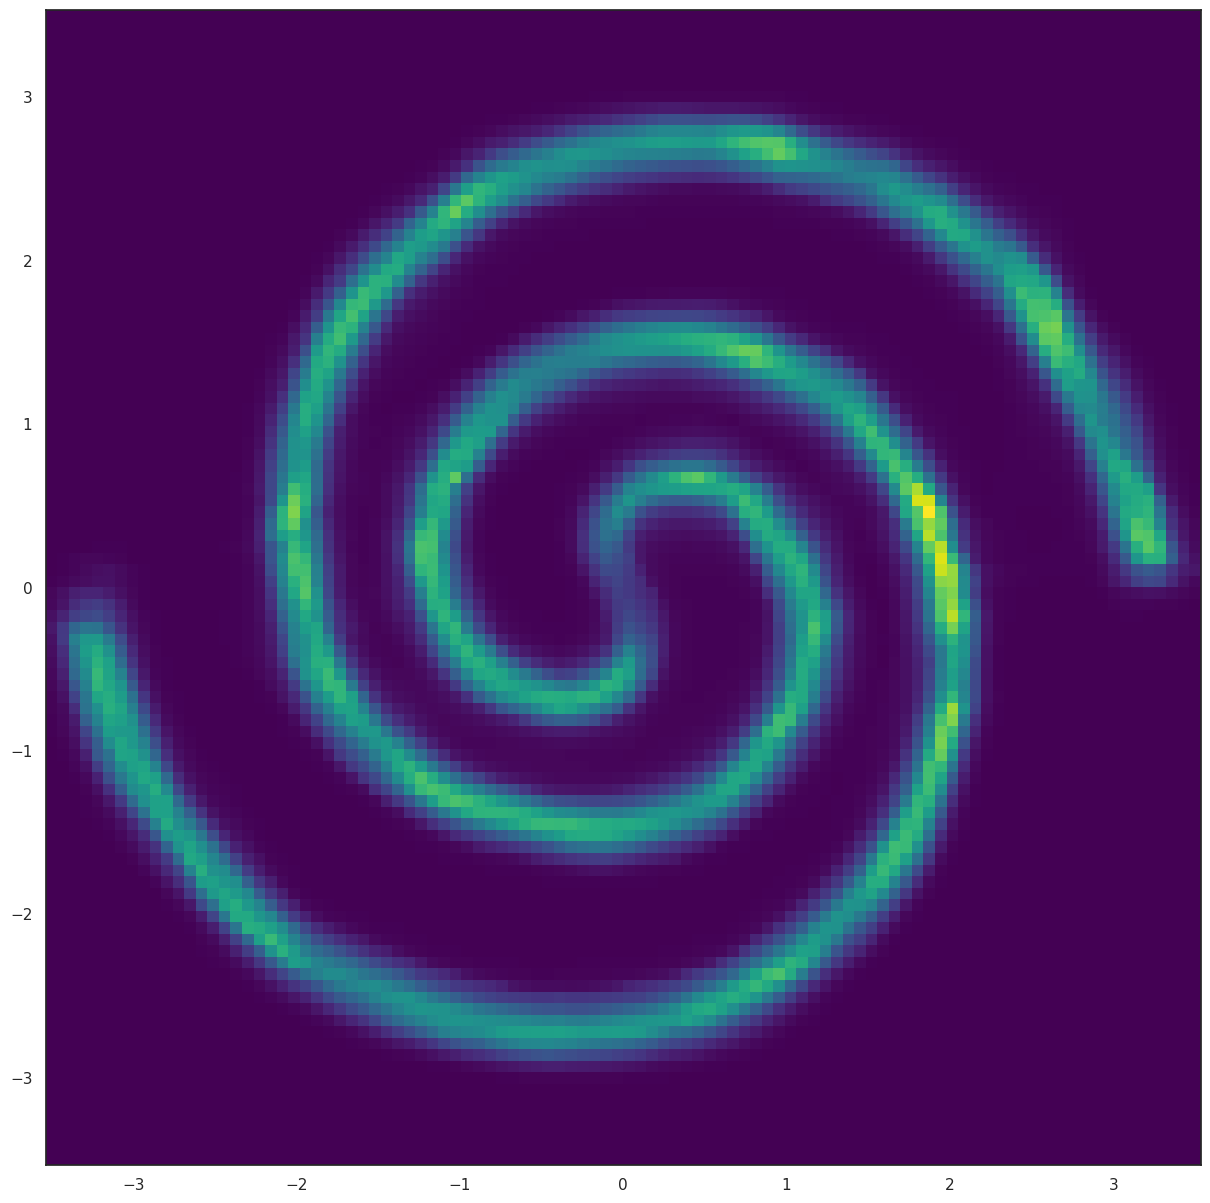

 45%|████▍     | 4499/10000 [08:14<10:11,  8.99it/s]

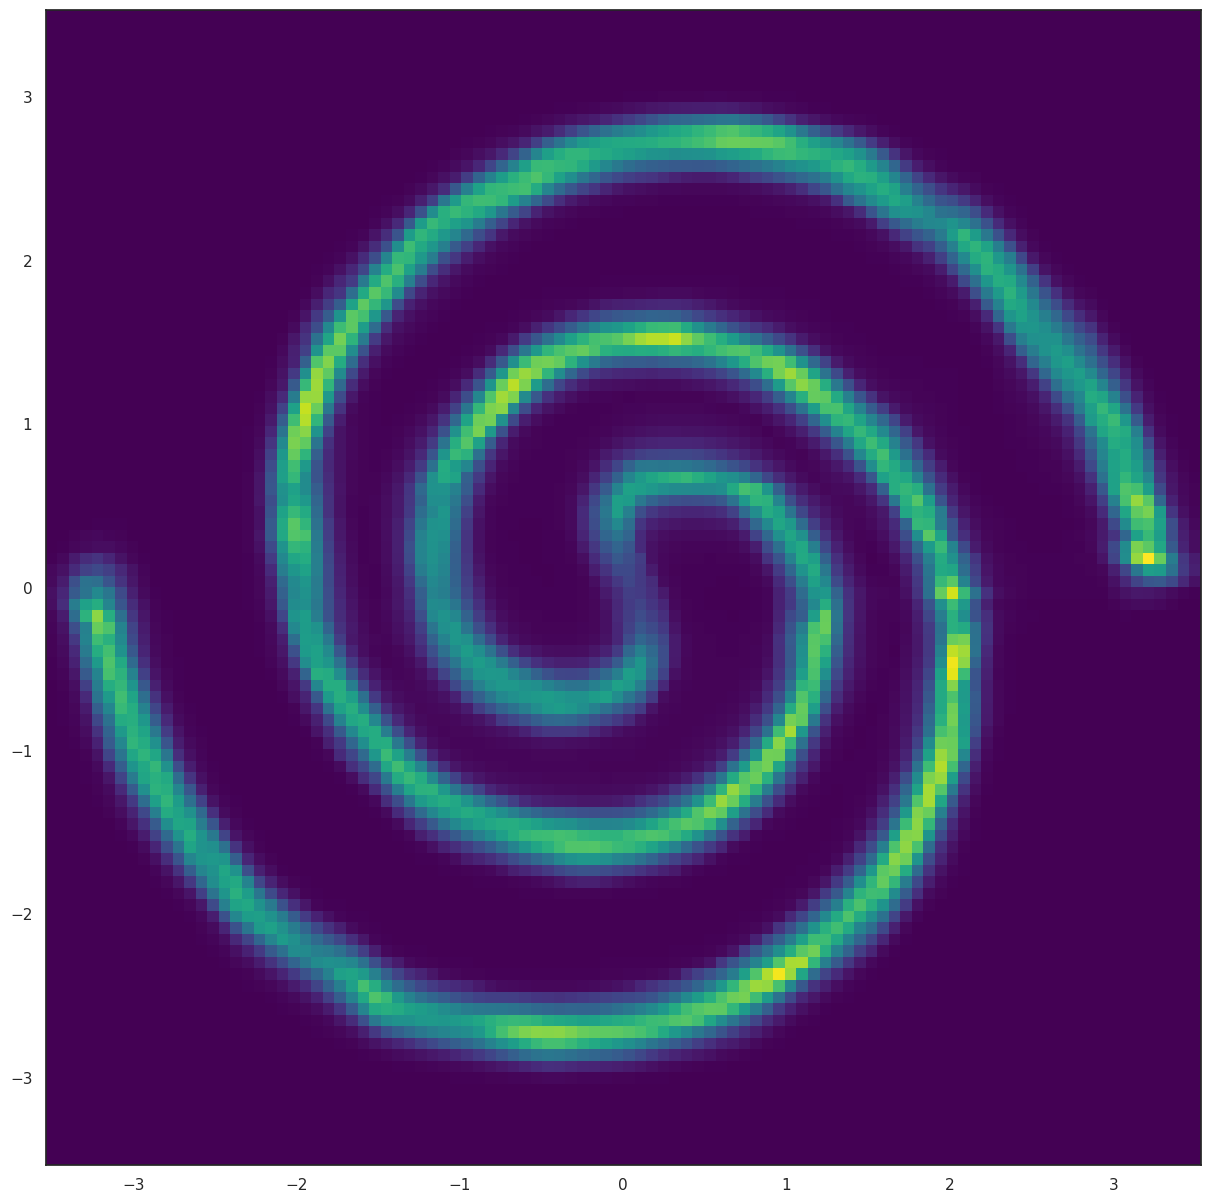

 50%|████▉     | 4999/10000 [09:07<08:30,  9.80it/s]

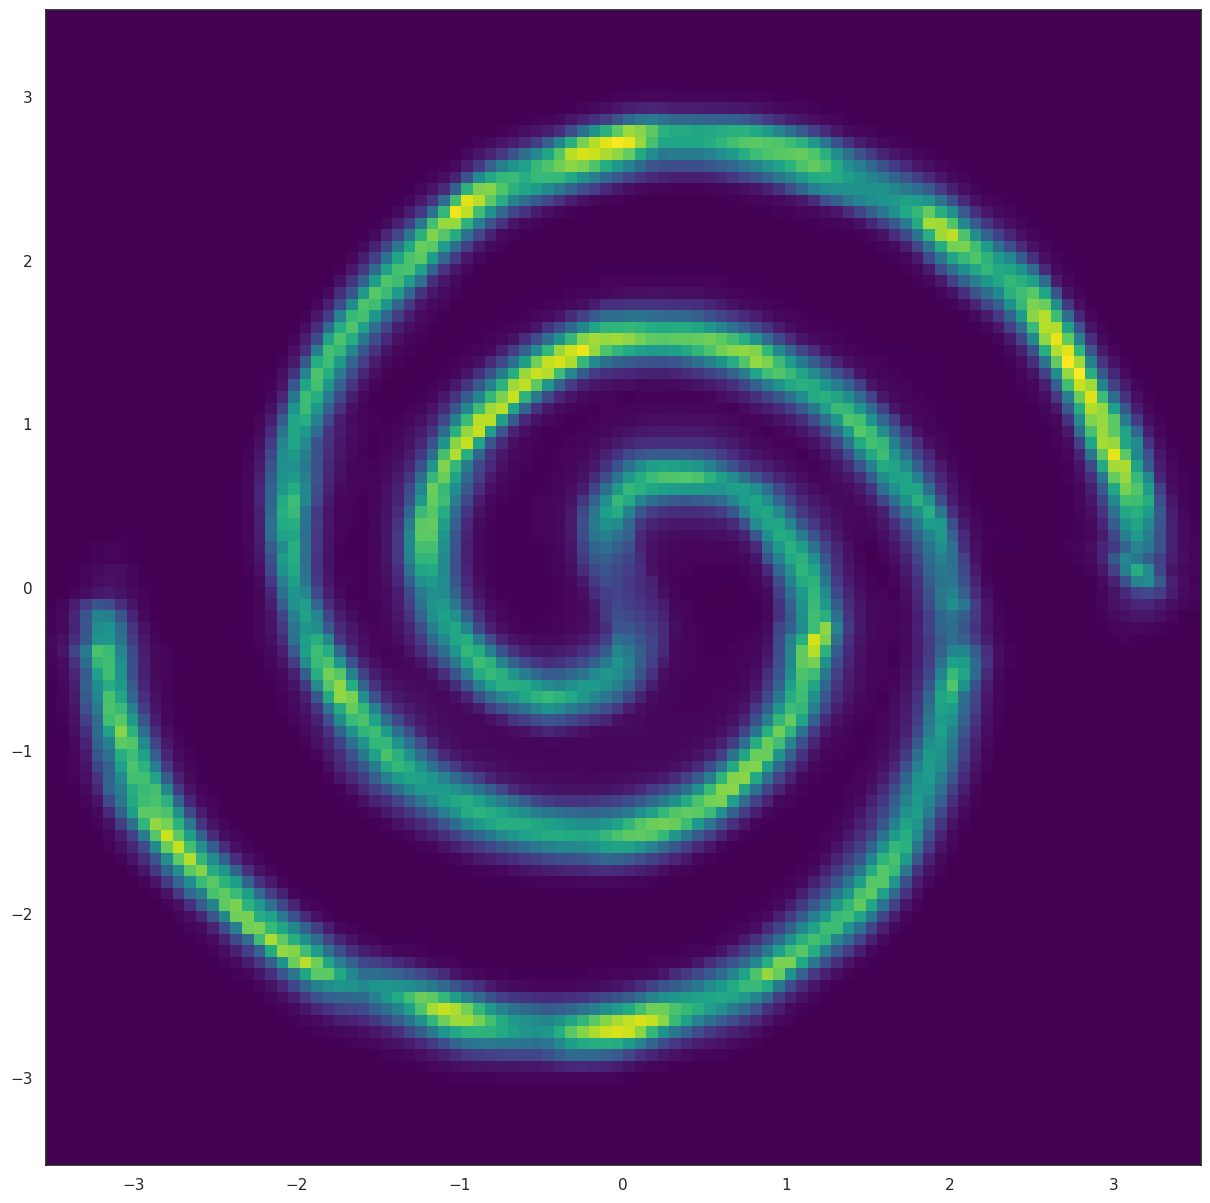

 55%|█████▍    | 5499/10000 [10:01<07:55,  9.47it/s]

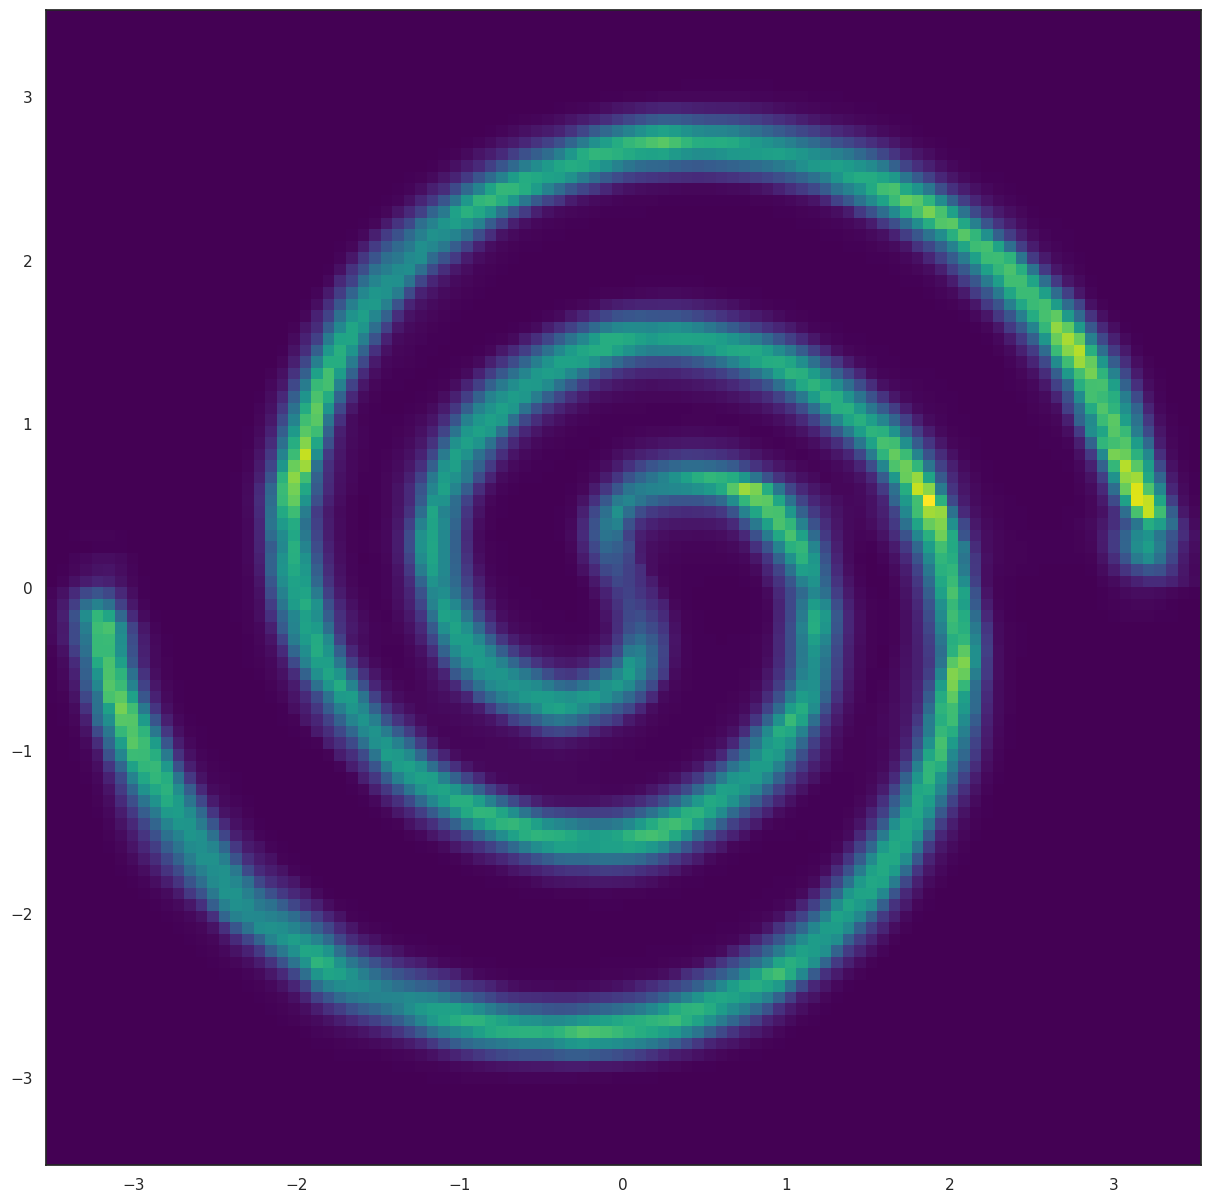

 60%|█████▉    | 5999/10000 [10:54<07:10,  9.30it/s]

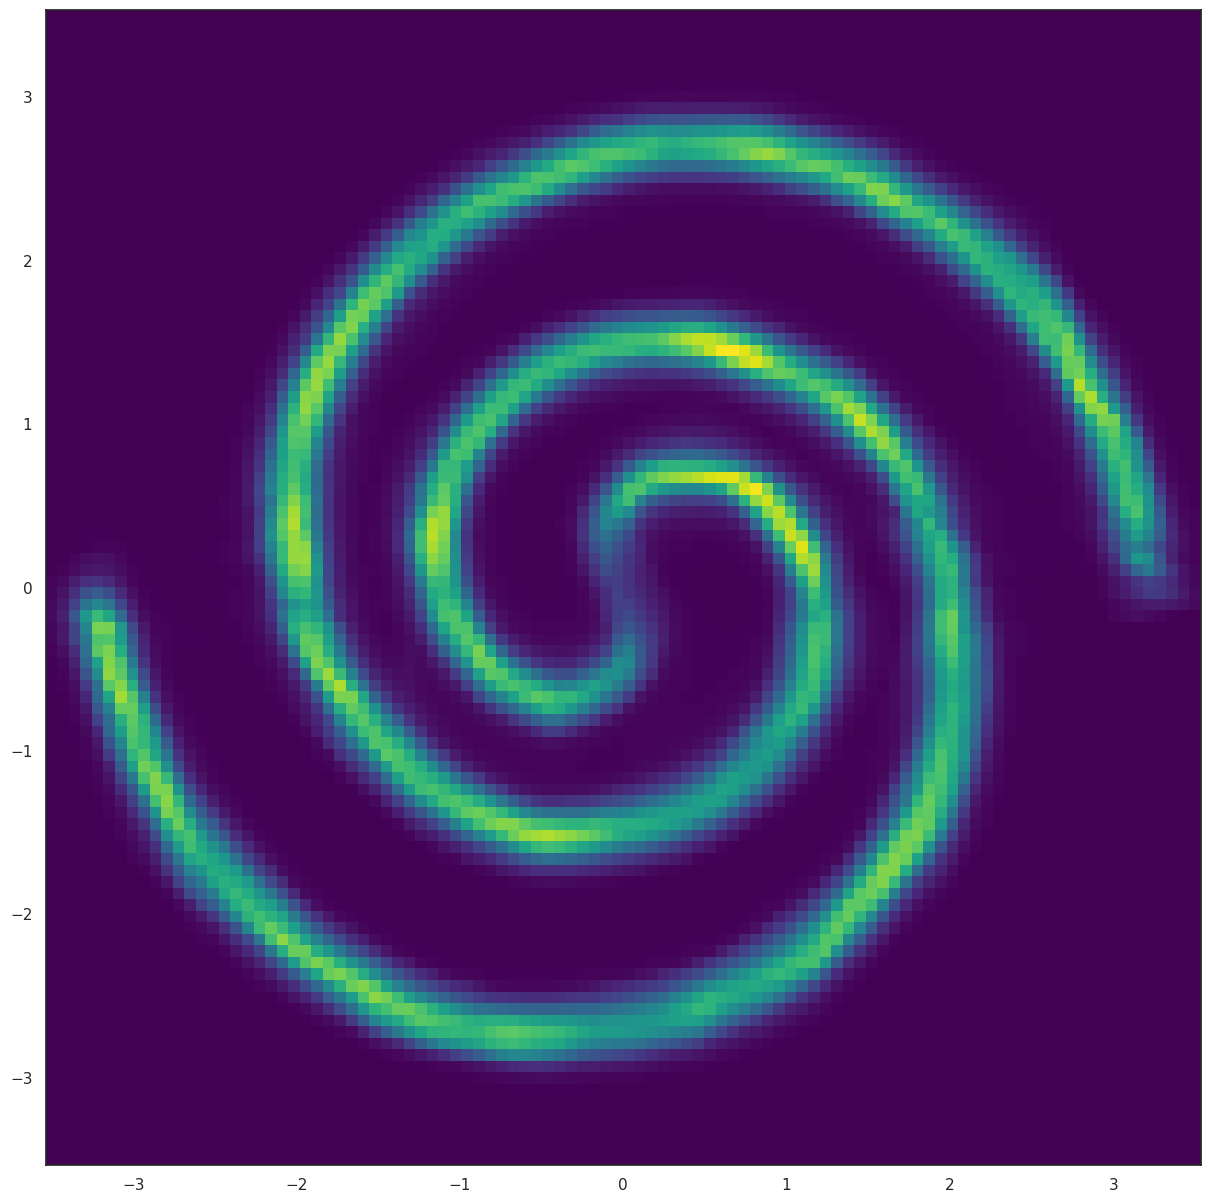

 65%|██████▍   | 6499/10000 [11:48<06:13,  9.37it/s]

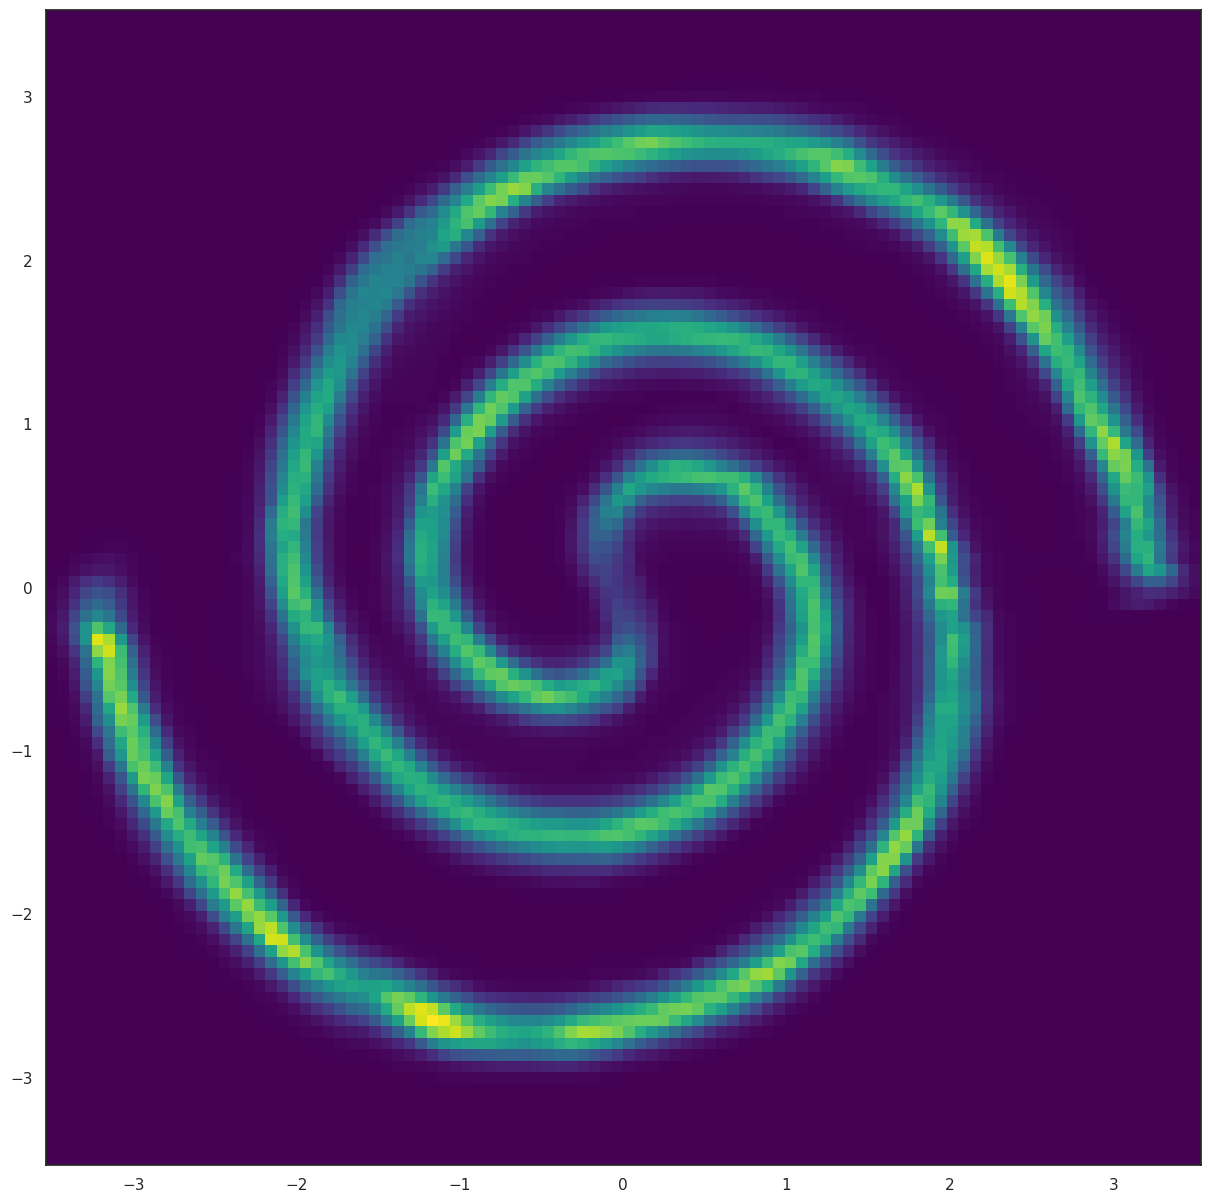

 70%|██████▉   | 6999/10000 [12:41<05:50,  8.56it/s]

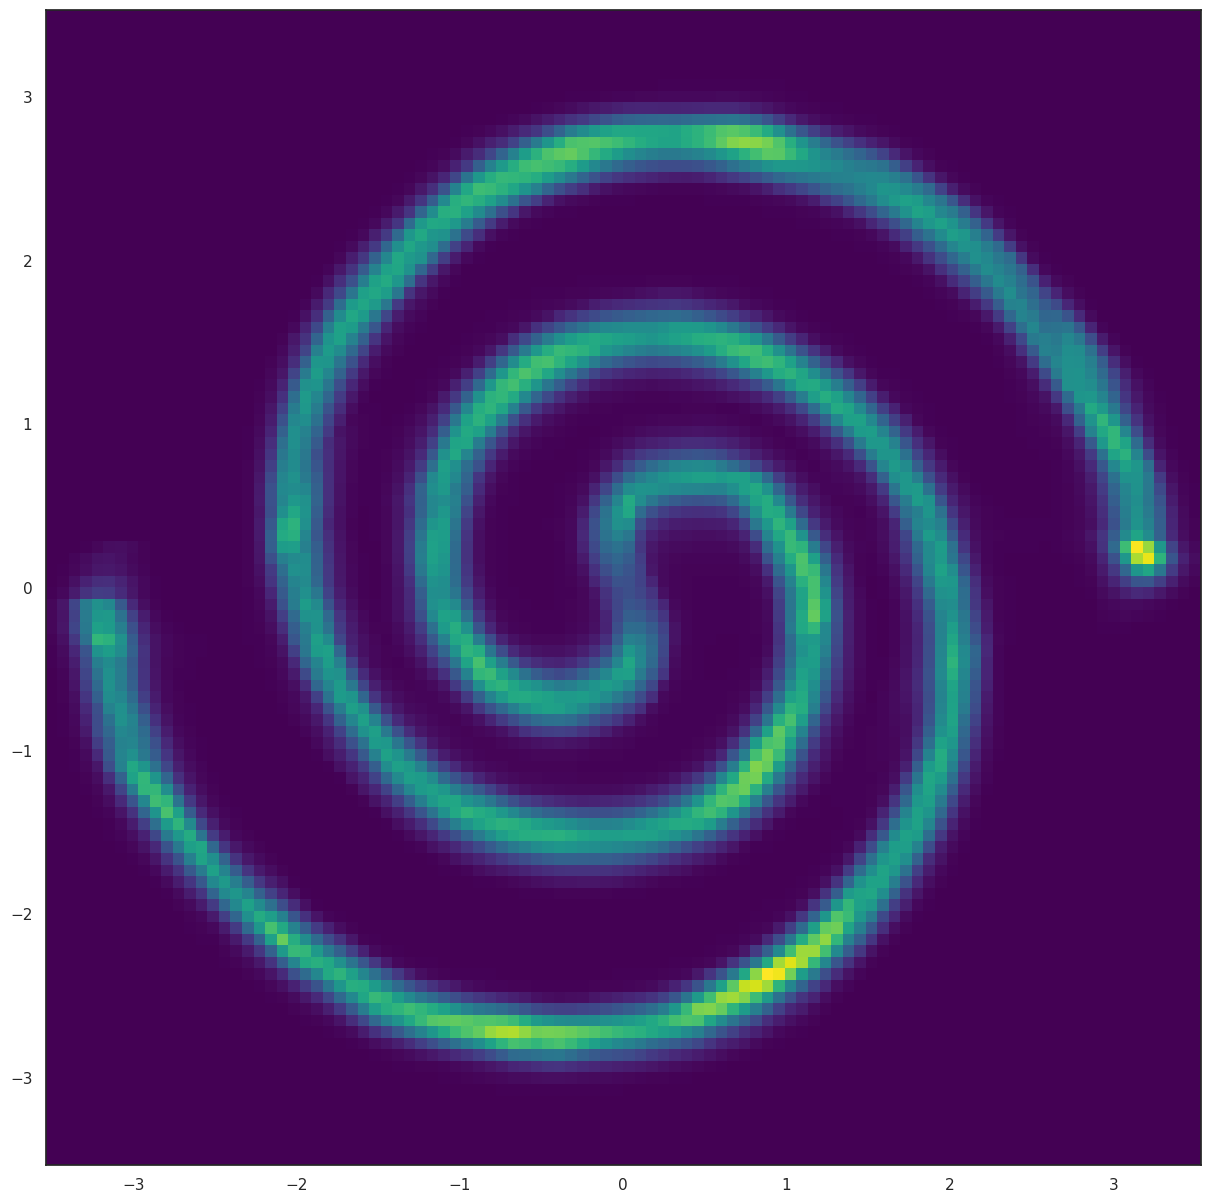

 75%|███████▍  | 7498/10000 [13:34<04:29,  9.30it/s]

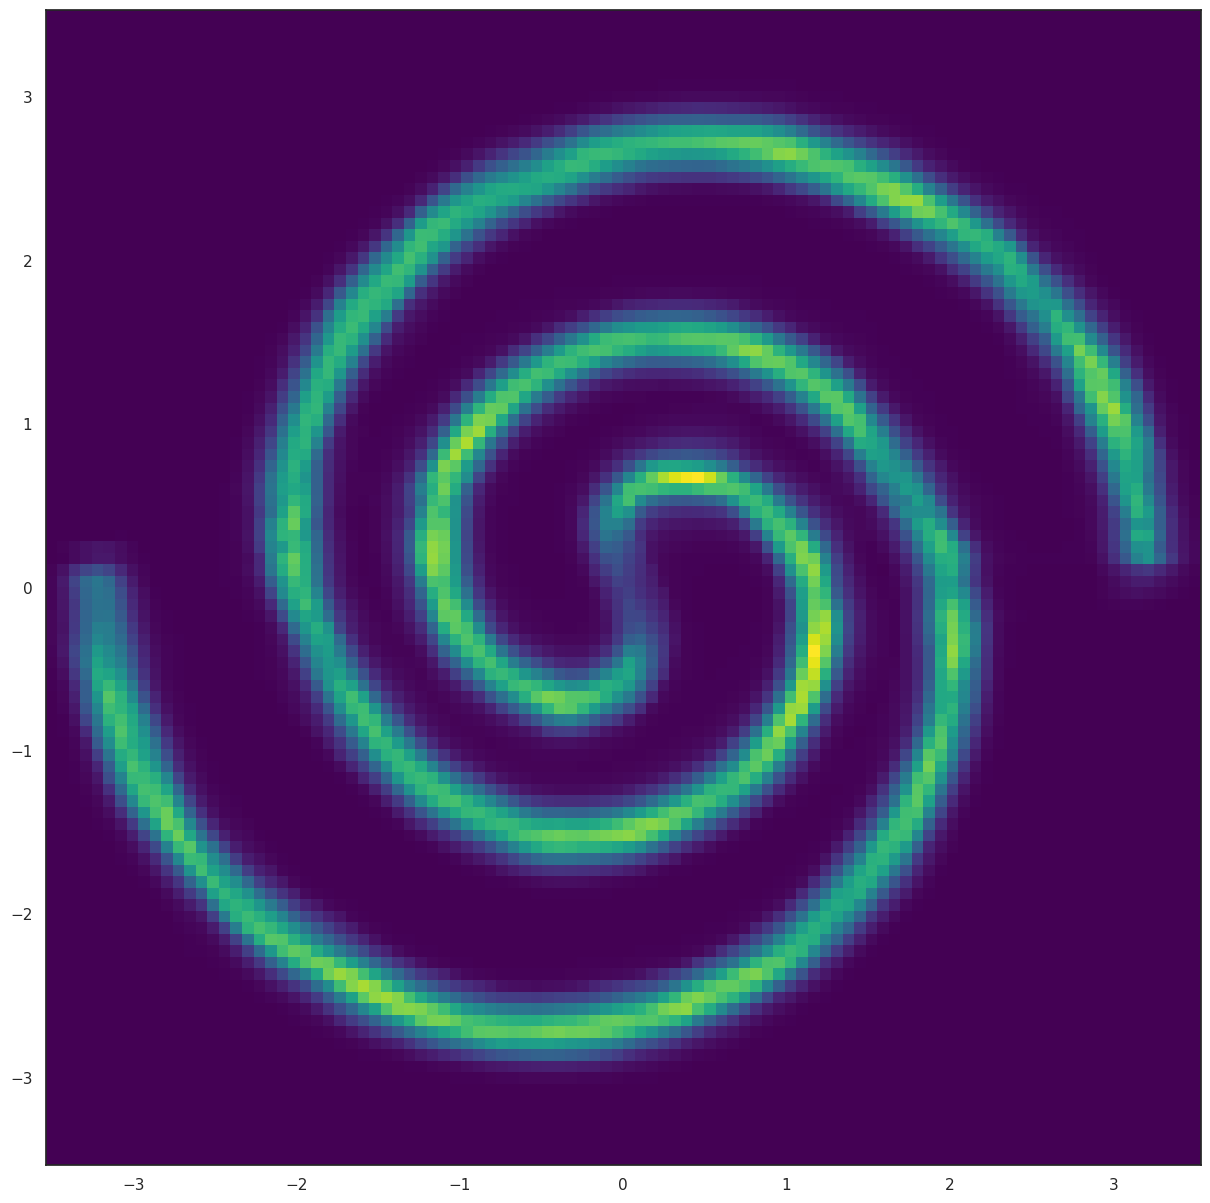

 80%|███████▉  | 7999/10000 [14:28<03:37,  9.18it/s]

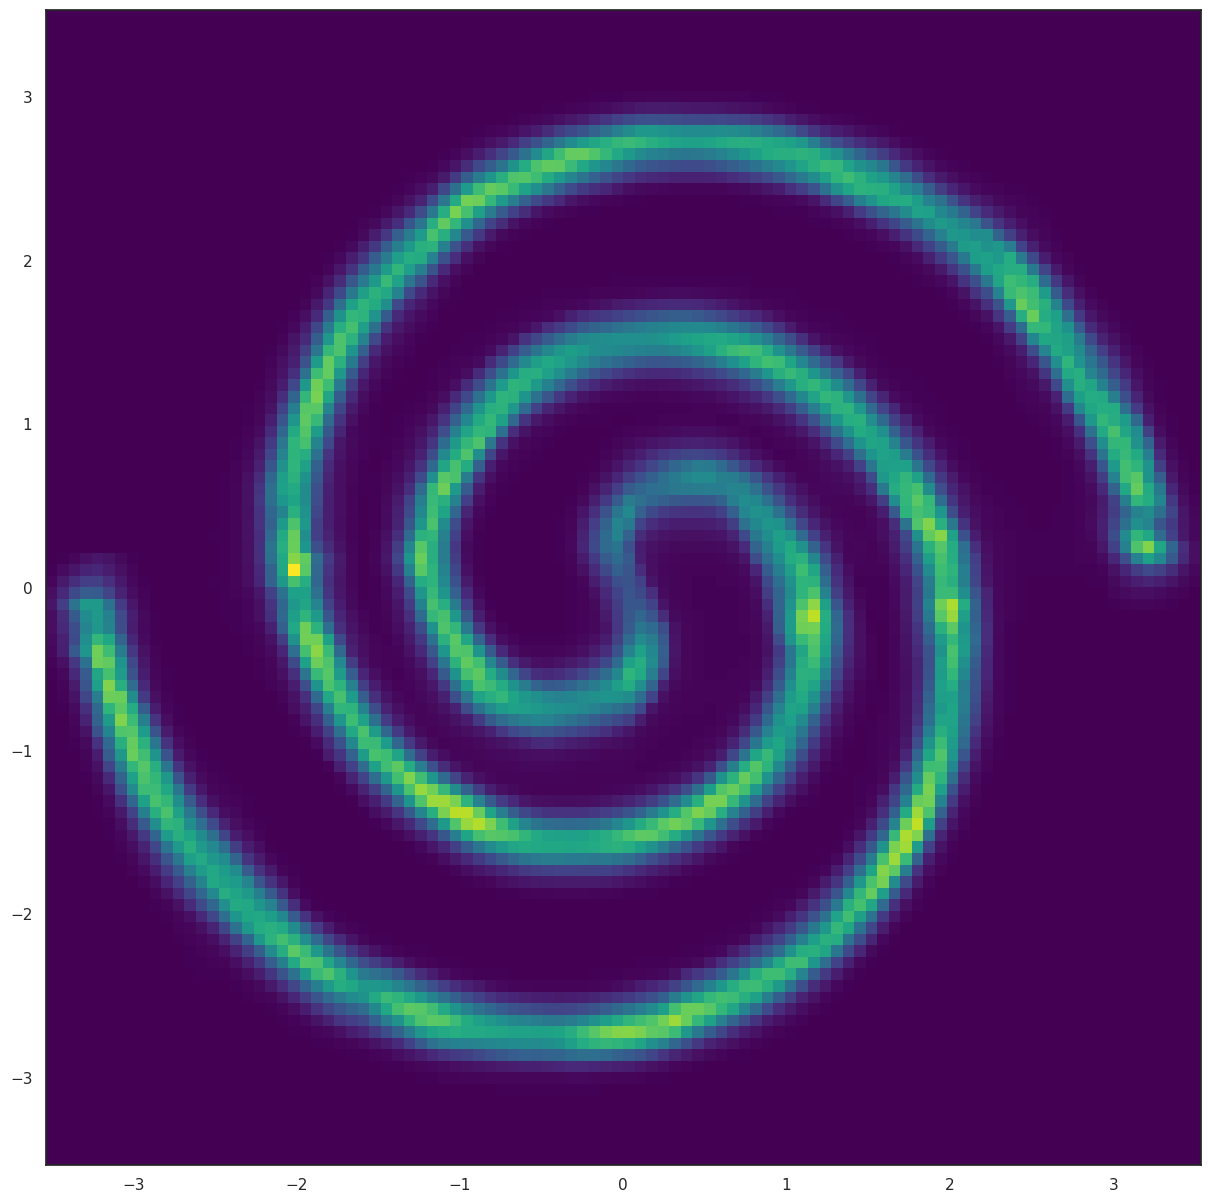

 85%|████████▍ | 8499/10000 [15:22<02:36,  9.62it/s]

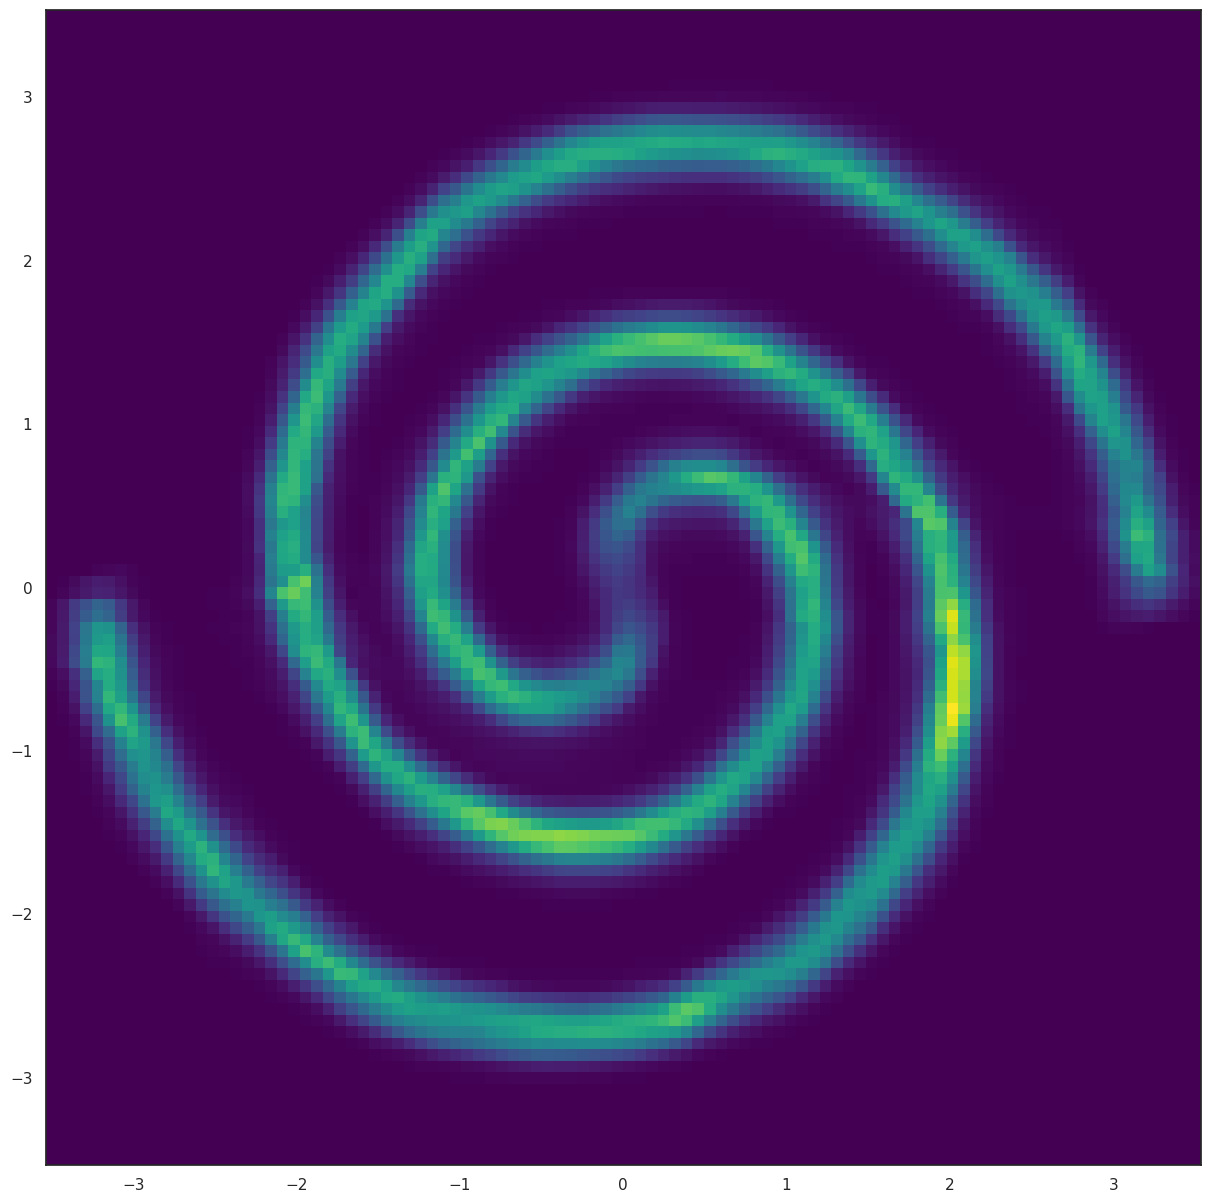

 90%|████████▉ | 8999/10000 [16:15<01:47,  9.32it/s]

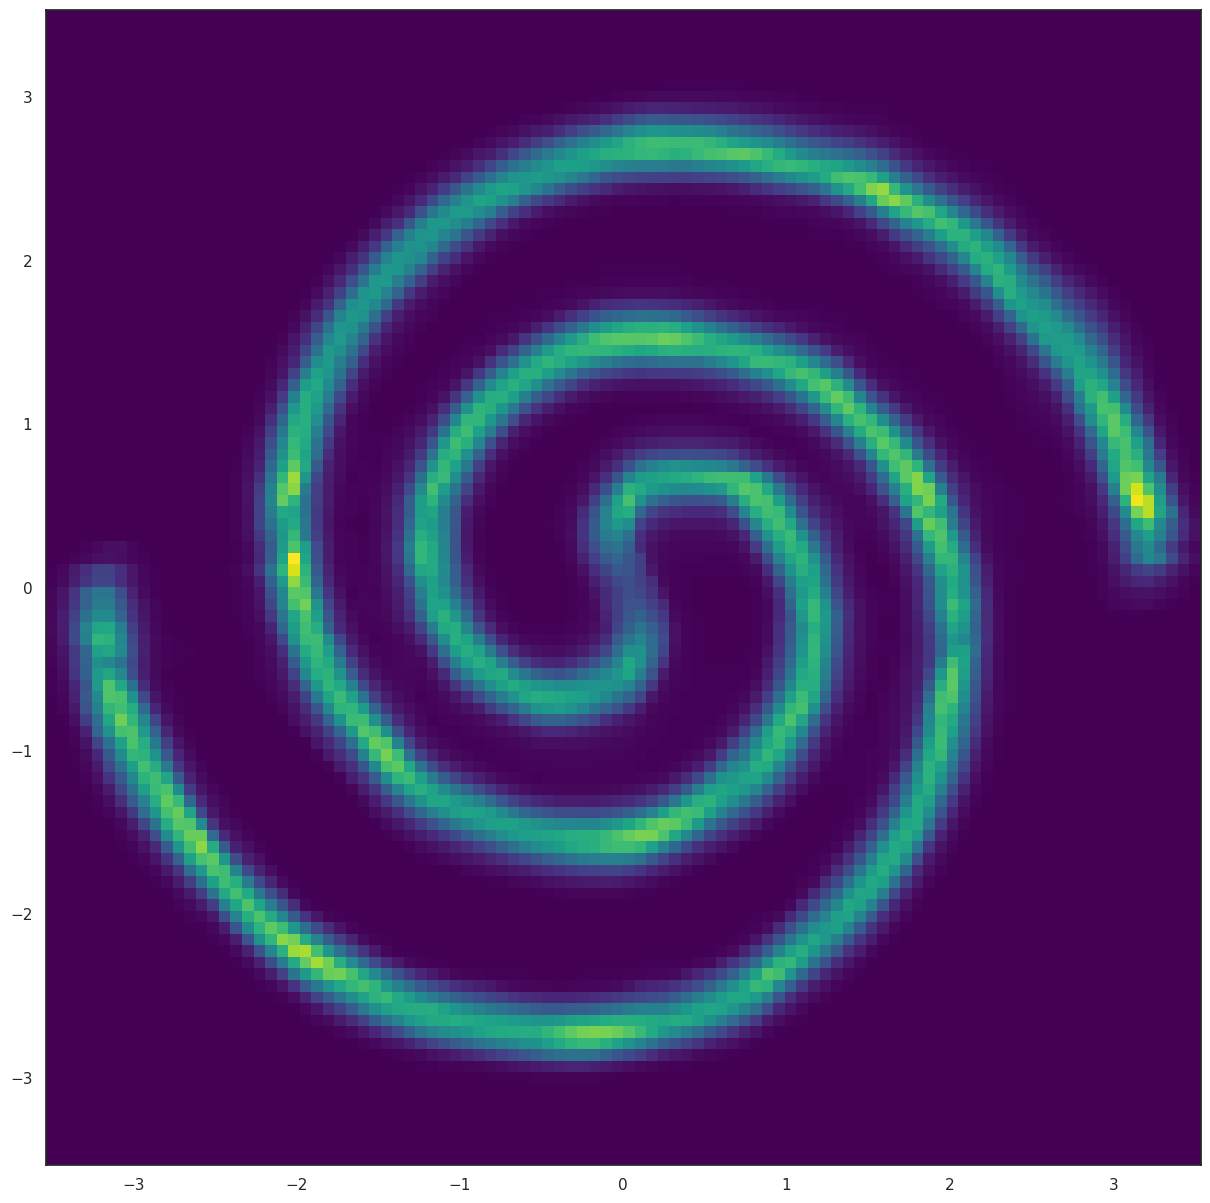

 95%|█████████▍| 9499/10000 [17:07<00:53,  9.45it/s]

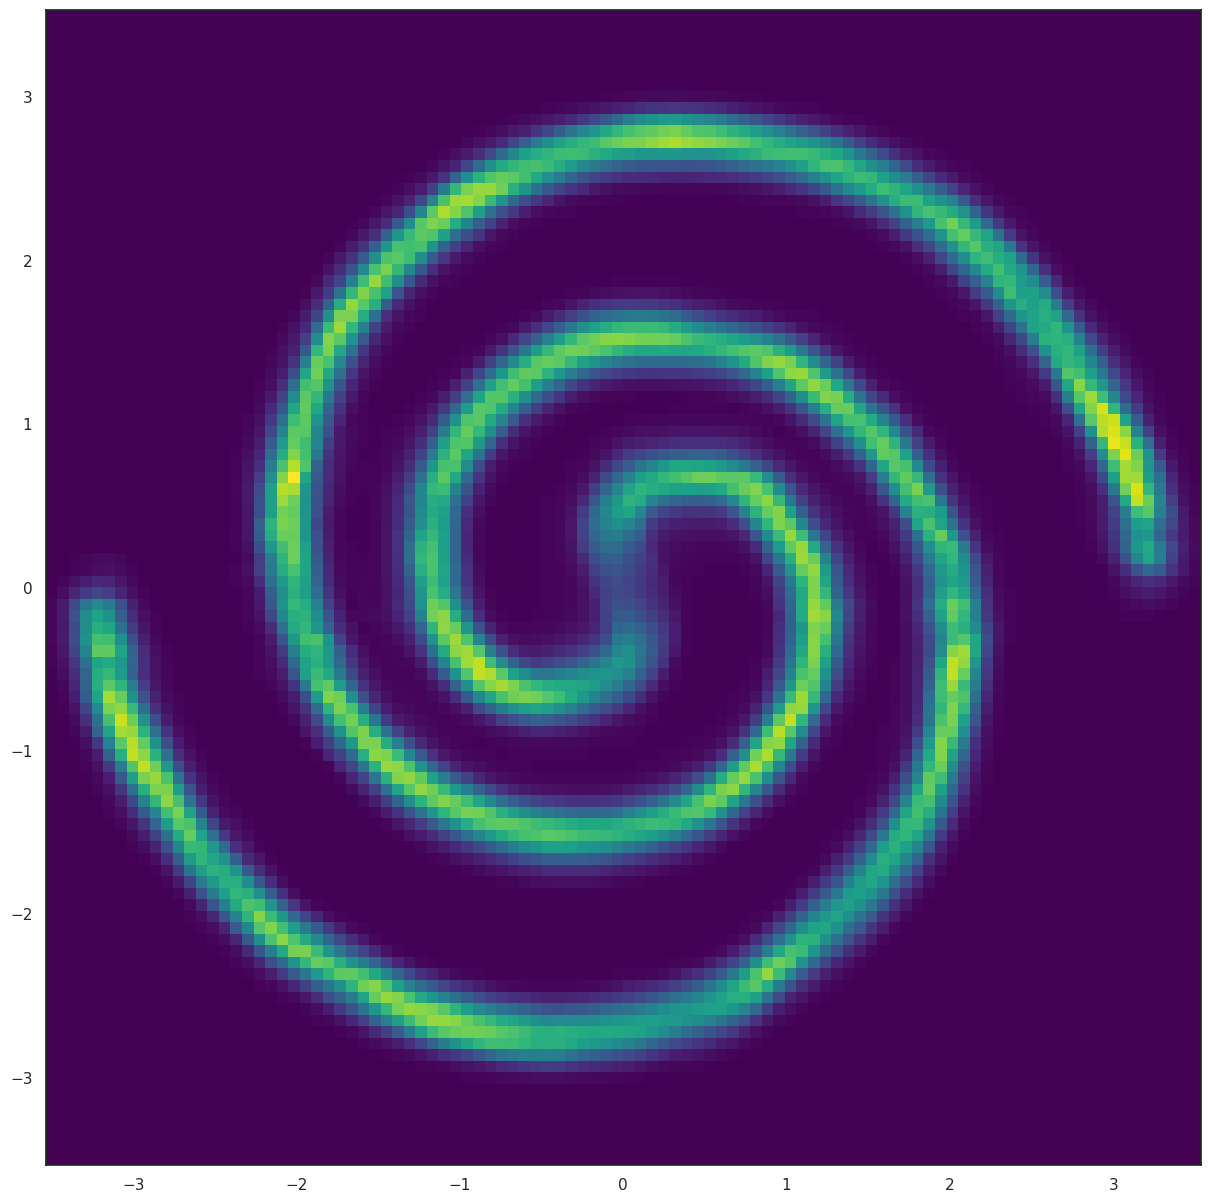

100%|█████████▉| 9999/10000 [18:01<00:00,  9.48it/s]

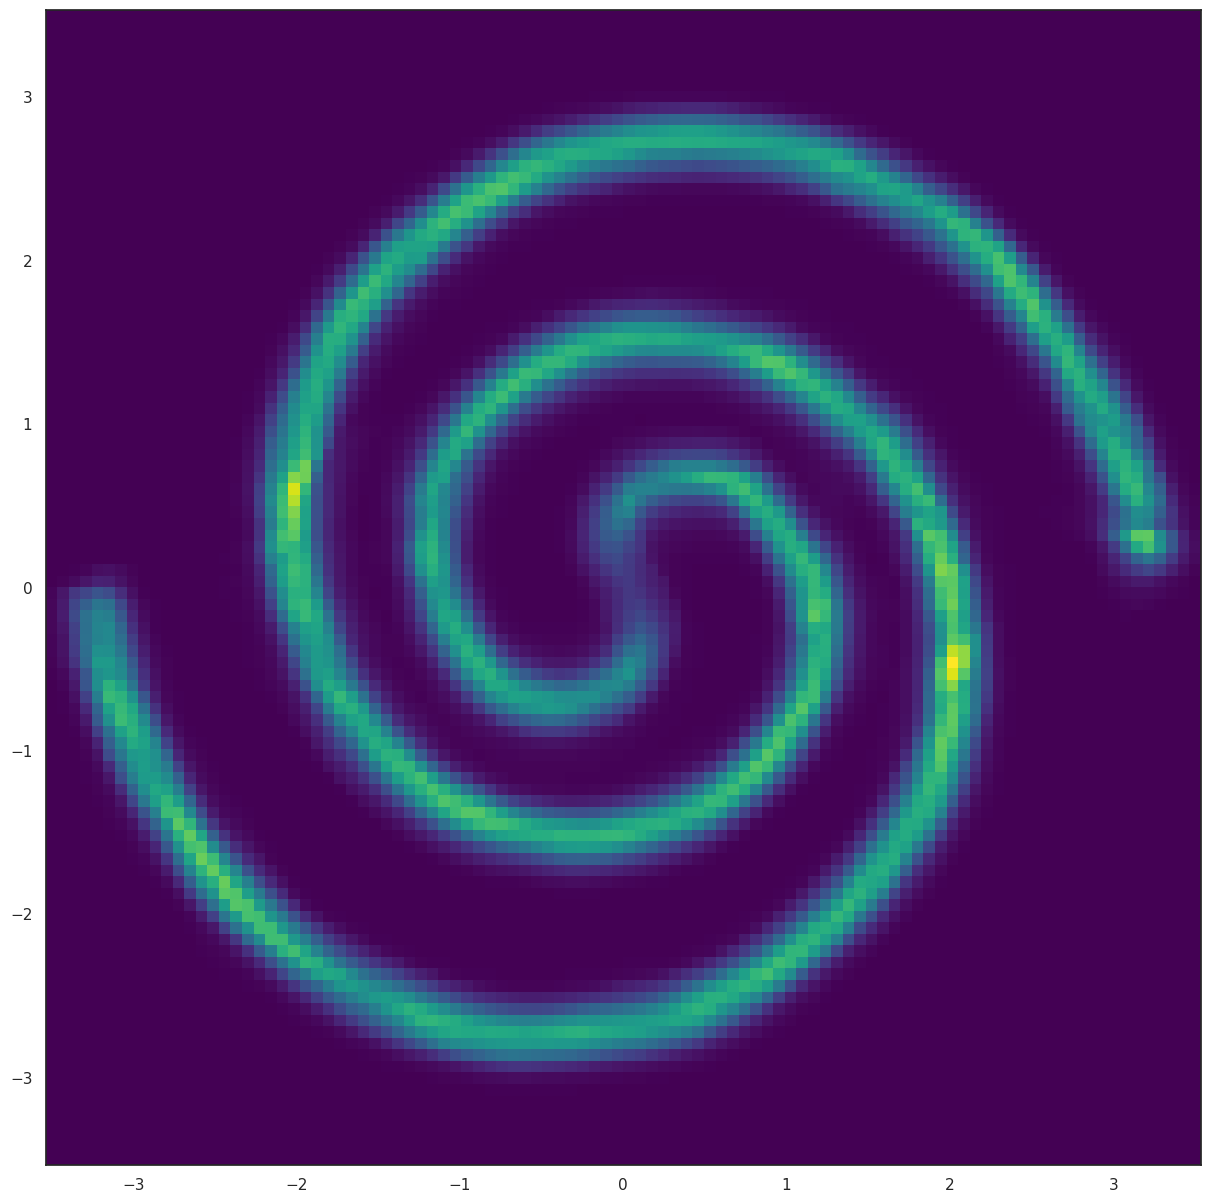

100%|██████████| 10000/10000 [18:02<00:00,  9.24it/s]


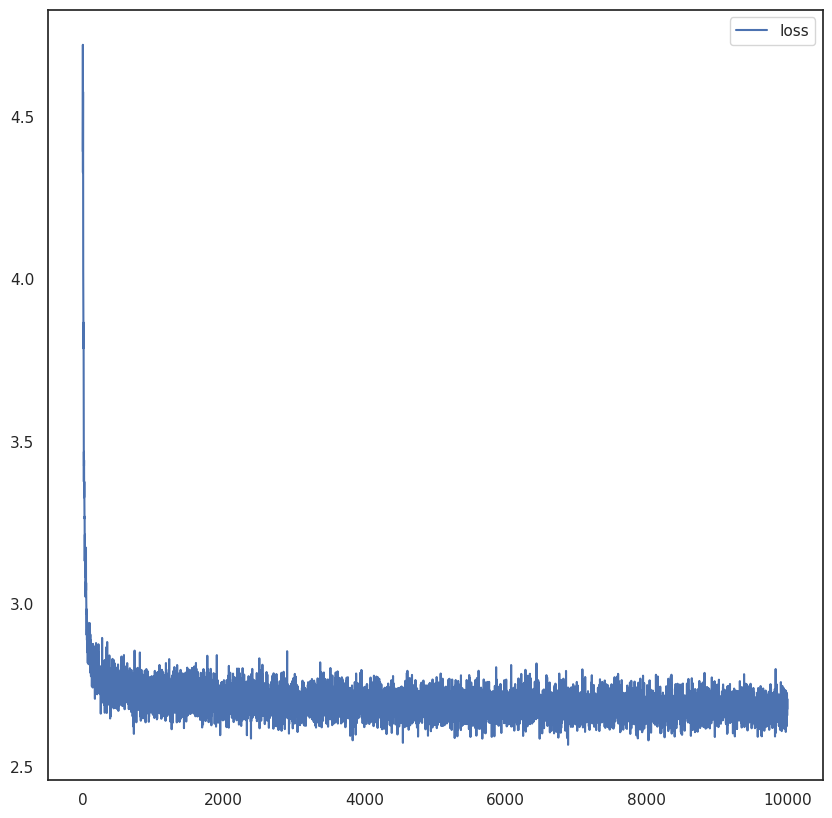

In [6]:
max_iter = 10000
num_samples = 2 ** 9 # per iteration
show_iter = 500

loss_hist = np.array([])

optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-3, weight_decay=1e-5)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()

    # get training samples
    x_np = two_spirals(num_samples)
    x = torch.tensor(x_np).float().to(device)

    # calculate loss
    loss = nfm.forward_kld(x)

    # backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)): # if loss is normal
        loss.backward()
        optimizer.step()
    
    # log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

    # plot leaned distribution
    if (it + 1) % show_iter == 0:
        nfm.eval()
        log_prob = nfm.log_prob(zz) # calculate the log-prob on points zz
        nfm.train()
        prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
        prob[torch.isnan(prob)] = 0 # assign prob=0 to those untrained points, in order to plot
        
        plt.figure(figsize=(15, 15))
        plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='viridis')
        plt.gca().set_aspect('equal', 'box')
        plt.show()

# plot the loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label="loss")
plt.legend()

Save the trained model checkpoint

In [ ]:
torch.save(nfm.state_dict(), f"../datasets/flow_synthetic_2d_checkpoints/spirals_{it}")

Load the trained model checkpoint, and sample from it, then plot samples to see the estimated data

In [6]:
# Define flow and load the pre-trained model into it
K = 16
torch.manual_seed(0)

latent_size = 2
hidden_units = 128
hidden_layers = 2

flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# set base distribution
q0 = nf.distributions.DiagGaussian(2, trainable=False)

# construct flow
model = nf.NormalizingFlow(q0=q0, flows=flows)

model.load_state_dict(torch.load("../datasets/flow_synthetic_2d_checkpoints/spirals_9999"))

# move model on GPU
enable_cuda = True
device = torch.device('cuda:0' if torch.cuda.is_available() and enable_cuda else 'cpu')
model = model.to(device)

cuda:0
torch.Size([50000, 2])


(-3.5, 3.5, -3.5, 3.5)

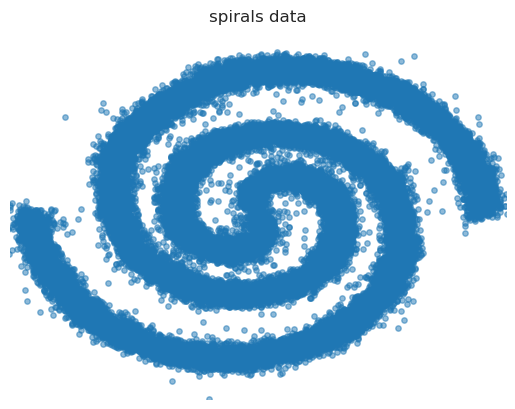

In [7]:
# Use this to generate training/validation datasets
model.eval()
with torch.no_grad():
    s, _ = model.sample(50000)
print(s.device)
print(s.shape)
s = s.cpu()
model.train()
plt.subplot(1,1,1)
plt.scatter(s[:,0], s[:,1], alpha=0.5, s=15)
plt.title("spirals data")
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)
plt.axis("off")


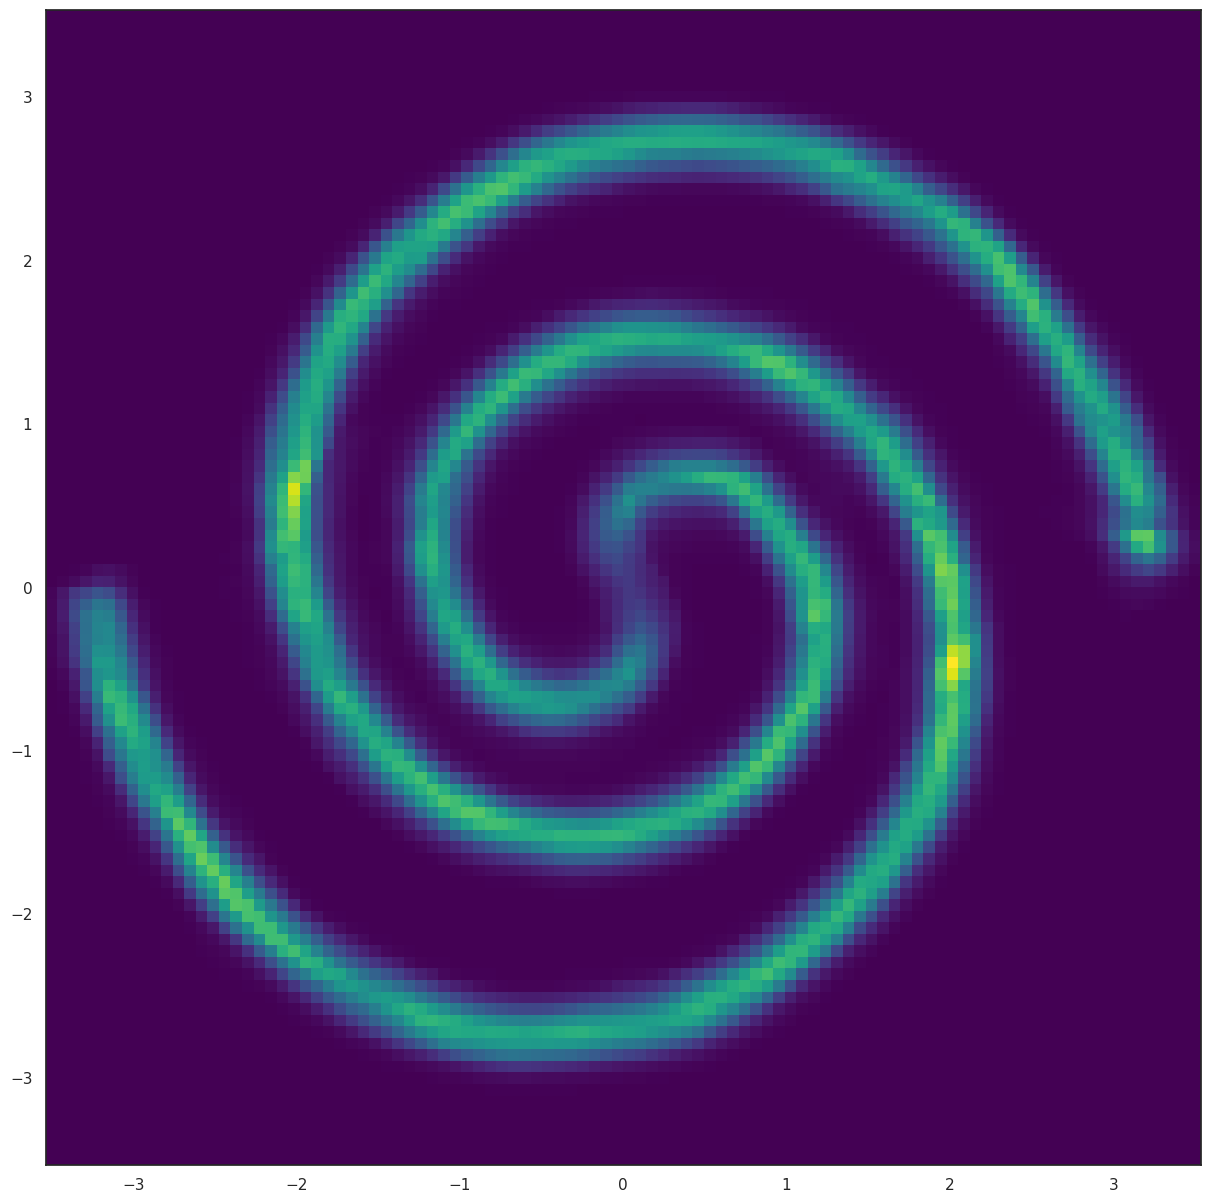

In [10]:
# plot the learned distribution, sanity check
nfm.eval()
log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
nfm.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='viridis')
plt.gca().set_aspect('equal', 'box')
plt.show()